In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as stat # extra statistical functions (the basic are included in numpy)

rcParams['figure.figsize'] = 10, 7
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

import astroML 
from astroML.plotting import setup_text_plots

import kplr
from kplr.ld import get_quad_coeffs
import time

import astropy
from astropy.stats import histogram 

For more colors: https://matplotlib.org/examples/color/named_colors.html

# Process Data

This is the same as the beginning of the notebook "Process Data".

In [2]:
path_file = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/clean_bat_files/LC_p13point5up/'
path_mergedLC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/merge_light_curves/LC_p13point5up_merged/'

properties_sample = pd.read_csv(path_file+'all_targets_P13point5up.csv', sep=',', comment='#')
targets = pd.read_csv(path_file + 'kepler_id.txt',delimiter=',', dtype=int, header=None, names=['kepid'])

df = pd.merge(targets, properties_sample, on=['kepid'], how='inner') 
sc_data = df.drop_duplicates('kepid') #remove duplicates (some systems have both sc and lc LC)

print("Check files:", sc_data.shape)


Check files: (56, 141)


In [3]:
class System:    
    def __init__(self, kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                time_BKJD, flux, flux_err, 
                t0, P, depth, b, duration, u1, u2, diffld, num_planets, incl, eccen, dor, sma,
                 transit_times,ind_missed_transits,
                rp, rp_err, teq, mp, 
                 trans_id, ftrans, ftrans_err, ttrans,dt_trans,
                res_transfit, full_P, full_P_trans, rd_P, full_stats, rd_stats, full_P_trans_stats):
        
        """****** Kepler Reported Stellar Parameters ******"""
        self.kepid = kepid
        self.rs = rs # [Solar radii]. 
        self.rs_err = rs_err
        self.smass = smass # [Solar mass]
        self.smass_err = smass_err
        
        self.teff = teff;     
        self.logg = logg; # Stellar Surface Gravity [log10(cm/s**2)]  
        self.feh = feh;   
        self.srho = srho; #g/cm3
        
        """****** LC parameters ******"""
        self.time_BKJD = time_BKJD
        self.flux = flux
        self.flux_err = flux_err
        
        """****** Transit Parameters ******"""
        self.t0 = t0
        self.P = P;            
        self.depth = depth;  
        self.b = b; 
        self.duration = duration; 
        self.u1 = u1; 
        self.u2 = u2
        self.diffld = 0.0
        self.num_planets = num_planets
        self.incl = incl #[º]
        self.eccen = 0.0
        self.dor = dor #Planet-Star Distance over Star Radius
        self.sma = sma #Orbital semi-major axis [AU]
        
        self.transit_times = transit_times
        self.ind_missed_transits = ind_missed_transits
        #self.depth = rprs ** 2 
            # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and 
            # neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), 
            # to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
                   
        """****** Planetary Parameters ******"""
        self.rp = rp # [Earth radii]. This is "prad"  in the original file
        self.rp_err = rp_err
        self.teq = teq
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. It requires Rp in Earth radii
        
        """****** Internal Variables ******"""
        self.trans_id = np.empty(0)
        self.ftrans = np.empty(0)
        self.ftrans_err = np.empty(0)
        self.ttrans = np.empty(0)
        self.dt_trans = np.empty(0)
        self.res_transfit = np.empty(0
                                    )
        self.full_P = np.empty(0)
        self.full_P_trans = np.empty(0)
        self.rd_P = np.empty(0)
        
        self.full_stats = np.empty(0)
        self.rd_stats = np.empty(0)
        self.full_P_trans_stats = np.empty(0)
        

In [4]:
bjd_ref = 2454833

def quadraticLD(T, G, FEH): 
    """Confirm the quadratic LD coefficients with a model from Claret & Bloemen (2011).
    Use the Claret coefficients instead."""
    mu1, mu2 = get_quad_coeffs(T, G, FEH)
    return (mu1, mu2)

def fetchLC(name):
    id_kep = "%.0f" % name
    lc = path_mergedLC+('KID'+id_kep+'.txt')
    df = pd.read_csv(lc, sep="\t", skiprows=1, header=None, names=["Time BKJD", "Flux", "Flux_Err"])
    y = df['Flux']
    yerr = df['Flux_Err']
    x = df['Time BKJD']
    #print(np.median(y),np.mean(y),np.std(y))
    return (y, yerr, x)

In [5]:
targets = []

for row in sc_data.itertuples(index = True, name='Pandas'):
    kepid = getattr(row, "kepid")
    fluxLC, fluxLC_err, timeLC_BKJD = fetchLC(kepid)

    ## Store the stellar parameters
    rs = getattr(row, "koi_srad") #solar radii
    smass = getattr(row, "koi_smass")
    #Assuming that we have a 5% error on radius and mass (this is sensible thanks to Gaia)
    rs_err = rs*0.05
    smass_err = smass*0.05

    teff = getattr(row, "koi_steff")
    logg = getattr(row, "koi_slogg") # Stellar Surface Gravity [log10(cm/s**2)]  
    feh = getattr(row, "koi_smet")
    srho = getattr(row, "koi_srho") #g/cm3
    
    #### Store LC Parameters
    t0 = getattr(row, "koi_time0bk")
    P = getattr(row, "koi_period") # Orbital Period [days]
    depth = getattr(row, "koi_depth")/1e6
    b = getattr(row, "koi_impact")
    
    u1, u2 = quadraticLD(teff,logg,feh)

    num_planets = getattr(row, "koi_count")
    incl =  getattr(row, "koi_incl") #in degrees
    dor = getattr(row, "koi_dor")  #Planet-Star Distance over Star Radius
    
    time0bk = getattr(row, "koi_time0bk")
    duration = getattr(row, "koi_duration")/24. #in days. "Duration is measured from first contact between the planet and star until last contact."
    
    #Planetary parameters
    sma = getattr(row, "koi_sma")  #Orbit Semi-Major Axis [AU]
    sma_solarRad = sma*215
    teq = getattr(row, "koi_teq") 
    rp = getattr(row, "koi_prad") # in Earth radii
    rp_solarRad = getattr(row, "koi_prad")*0.009168 # in solar radii
    rp_errPos = getattr(row, "koi_prad_err1"); rp_errNeg = getattr(row, "koi_prad_err2")
    rp_err = np.abs((rp_errPos+rp_errNeg)/2.)
        
    
    if (num_planets == 1):
        system = System(kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                    timeLC_BKJD, fluxLC, fluxLC_err, 
                    t0, P, depth, b, duration, u1, u2, u1-u2, num_planets, incl, 0.0, dor, sma,
                        None, None,
                    rp, rp_err, teq, None, 
                        None, None, None, None, None,
                       None, 
                        None, None, None, None, None, None)

        targets.append(system)

In [6]:
def find_transits(star):
    ti = min(star.time_BKJD)
    tf = max(star.time_BKJD)
    
    n_min = int((ti-star.t0)/star.P)
    n_max = int((tf-star.t0)/star.P+1.)
    n = np.arange(n_min, n_max)
    
    t = star.t0+n*star.P
    t = t[t>ti] 
    t = t[t<tf]
    return(t)

def show_folded_lightcurve(star, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.dt_trans,star.ftrans,'.')     
        plt.title(r'Folded LC for KID'+str(star.kepid))
        plt.xlabel(r'Time BKJD [d]'); plt.ylabel('Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.3)
        plt.close()

def mark_transits(star, obs_trans, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.time_BKJD,star.flux,'.')        
        for j in range(len(star.transit_times)): 
            plt.axvline(star.transit_times[j], color='k', ls='-')
        for k in range(len(obs_trans)): 
            plt.axvline(obs_trans[k], color='r', ls='--')
        plt.title(r'KID'+str(star.kepid))
        plt.xlabel(r'Time BKJD [d]'); plt.ylabel(r'Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.3)
        plt.close()
        
def show_transits(star, bad_trans, plot=False):        
    s1 = set(bad_trans)
    if plot==True:   
        for i in range(len(star.transit_times)):
            if (i not in bad_trans):
                plt.figure(figsize=(15,6))
                plt.title('Folded Light Curve')
                plt.plot(star.ttrans[star.trans_id==i]-star.transit_times[i],star.ftrans[star.trans_id==i], 'k.')     
                plt.title("Transit "+str(i+1))
                plt.xlabel(r'Time [d]'); plt.ylabel('Normalized Flux')
                plt.show(block=False)    
                time.sleep(0.3)
                plt.close()

In [7]:
def find_missed_transits(star):
    gaps = []
    for i in range(len(star.transit_times)):
        if len(star.ttrans[star.trans_id==i])==0: 
            gaps.append(i)
    missing_transits = sorted(gaps, reverse=True)
    return(missing_transits)

def get_data_in_transit(star, factor):
    window = factor*star.duration # In days
    total_points = 0
    
    for i in range(0,len(star.transit_times)):
        residual = star.time_BKJD - star.transit_times[i]
        points_in_transit = np.abs(residual) <= window
        total_points += np.sum(points_in_transit)

    time_in_transit = np.empty(total_points)
    flux_in_transit = np.empty(total_points)
    flux_err_in_transit = np.empty(total_points)
    flag_transit = np.empty(total_points)
    mid_trans = np.empty(total_points)

    total_points = 0

    for i in range(0, len(star.transit_times)):
        points_in_transit = np.abs(star.time_BKJD - star.transit_times[i]) <= window
        count_points = np.sum(points_in_transit)
        time_in_transit[(0 + total_points):(count_points + total_points)] = star.time_BKJD[points_in_transit]
        flux_in_transit[(0 + total_points):(count_points + total_points)] = star.flux[points_in_transit] #, star.flux_err[points_in_transit])[0]
        flux_err_in_transit[(0 + total_points):(count_points + total_points)] = star.flux_err[points_in_transit] #normalize(star.flux[points_in_transit], 
        flag_transit[(0 + total_points):(count_points + total_points)] = i
        mid_trans[(0 + total_points):(count_points + total_points)] = star.transit_times[i] 
        total_points += count_points
        
        
    star.trans_id = flag_transit
    star.ttrans = time_in_transit
    star.ftrans = flux_in_transit
    star.ftrans_err = flux_err_in_transit
    star.dt_trans = time_in_transit - mid_trans #if interested in the folded LC, plot target.dt_trans vs target.ftrans

In [8]:
def oot_fit(star, polyorder, factor):
    window = factor*star.duration 
    transit_range = window/2 # In days
    for i in range(0, len(star.transit_times)):
        transitBool = (star.trans_id == i)
        outsideBool = (np.abs(star.dt_trans) >= transit_range) & transitBool
        f_out = star.ftrans[outsideBool]
        num_oot_points = len(star.dt_trans[outsideBool])
        rms = np.sqrt(np.mean(f_out**2))
        
        if  (num_oot_points!= 0):  
            z = np.polyfit(star.dt_trans[outsideBool], f_out, polyorder)
            p = np.poly1d(z)
            star.ftrans[transitBool] = star.ftrans[transitBool]/p(star.dt_trans[transitBool]) # Divide transit by fit.
            
            snr_trans = np.mean(star.ftrans[transitBool])/np.std(star.ftrans[transitBool])
            #print("Transit #{0:s}: \t RMS={1:0.5f}\tflux_min={2:0.4f}".format(str(i+1),rms,min(star.ftrans[transitBool])))

In [9]:
stars_wo_transits = []
medfilter = 13
poly_order = 2
amplify = 1.5

for target in targets:
    #print("\n**** KID"+str(target.kepid)+" ****\n")
    target.transit_times = find_transits(target)
    get_data_in_transit(target, amplify)
    oot_fit(target, poly_order, amplify)
    if (len(target.transit_times)==0): stars_wo_transits.append(target.kepid)
    target.ind_missed_transits = find_missed_transits(target)
    observed_transits = np.delete(target.transit_times, target.ind_missed_transits)
    mark_transits(target, observed_transits, False)
    show_transits(target, target.ind_missed_transits, False)
    if len(observed_transits!=0): show_folded_lightcurve(target, False)

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Period Analysis

In [40]:
def plot_periods(star, upper_bound):
    fig = plt.figure(figsize=(20,18))
    #fig = plt.figure(figsize=(17,20))
    ax=fig.add_subplot(211)
    for i in range(len(star.full_P_trans)):
        ax.hist(star.full_P_trans[i]['Period'], density = True, bins=15, histtype='step', label='Transit '+str(i+1));
    ax.set_title('KID'+str(star.kepid)+' - Transit Period distribution', fontsize = 20)
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period' )
    plt.axvline(x = star.full_stats['mode'][0], color = 'b', ls = 'dashed', lw = 3, label = 'Mode')
    plt.axvline(x = star.full_stats['mean'][0], color = 'k', ls = 'dashed', lw = 3, label = 'Mean')
    plt.axvline(x = star.full_stats['median'][0], color = 'r',  ls = 'dashed', lw = 3, label = 'Median')
    plt.axvline(x = star.full_stats['16%'][0], color = 'k', ls = ':', lw = 3, label = '16%')
    plt.axvline(x = star.full_stats['50%'][0], color = 'm', ls = ':', lw = 3, label = '50%')
    plt.axvline(x = star.full_stats['84%'][0], color = 'g', ls = ':', lw = 3, label = '84%')
    ax.set_xlabel(r'$P$ [d]')
    ax.set_ylabel('Frequency')
    ax.set_xlim([10,star.full_stats['min'][0]*4])
    #ax.set_yscale('log')
    if (len(star.transit_times) < 10): ax.legend(loc='best', fontsize = 12)

    ax=fig.add_subplot(212)
    ax.set_title('KID'+str(star.kepid)+' - Full Period Distribution', fontsize = 20)
    ax.hist(star.full_P['Period'], bins=70, density = True, color='steelblue', alpha = 0.5) 
    ax.set_xlabel(r'$P$ [d]')
    ax.set_ylabel('Frequency')
    ax.set_xlim([star.full_stats['min'][0]-5,star.P+20])
    #ax.set_yscale('log')
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period')
    plt.axvline(x = star.full_stats['mode'][0], color = 'b', ls = 'dashed', lw = 3, label = 'Mode')
    plt.axvline(x = star.full_stats['mean'][0], color = 'k', ls = 'dashed', lw = 3, label = 'Mean')
    plt.axvline(x = star.full_stats['median'][0], color = 'r',  ls = 'dashed', lw = 3, label = 'Median')
    plt.axvline(x = star.full_stats['16%'][0], color = 'k', ls = ':', lw = 3, label = '16%')
    plt.axvline(x = star.full_stats['50%'][0], color = 'm', ls = ':', lw = 3, label = '50%')
    plt.axvline(x = star.full_stats['84%'][0], color = 'g', ls = ':', lw = 3, label = '84%')
    ax.legend(loc = 'best', fontsize = 12)
    plt.show()
    plt.tight_layout()
    plt.close(fig)

    """
    ax=fig.add_subplot(313)
    ax.set_title('KID'+str(star.kepid)+' - Full Period Distribution')
    ax.hist(star.full_P['Period'], bins = 50,  density = True, color='steelblue', alpha = 0.5) 
    ax.set_xlabel(r'$P$ [d]')
    ax.set_ylabel('Frequency')
    #ax.set_yscale('log'); 
    ax.set_xlim([star.full_stats['min'][0]-5,star.P+10])
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period')
    plt.axvline(x = star.full_stats['16%'][0], color = 'k', ls = ':', lw = 3, label = '16% (f) ')
    plt.axvline(x = star.full_stats['50%'][0], color = 'm', ls = ':', lw = 3, label = '50% (f) ')
    plt.axvline(x = star.full_stats['84%'][0], color = 'g', ls = ':', lw = 3, label = '84% (f)')
    ax.legend(loc = 'best')
    
    ax.set_title('KID'+str(star.kepid)+' - Full Period Distribution (Mask)')
    ax.hist(star.rd_P['Period'], bins = 100, density = True, color='steelblue', alpha = 0.5)
    ax.set_xlabel(r'$P$ [d]')
    ax.set_ylabel('Frequency')
    ax.set_xlim([10, upper_bound])
    ax.set_yscale('log')
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period')
    plt.axvline(x = star.rd_stats['16%'][0], color = 'k', ls = '--', lw = 2, label = '16% (r)')
    plt.axvline(x = star.rd_stats['50%'][0], color = 'm', ls = '--', lw = 2, label = '50% (r)')
    plt.axvline(x = star.rd_stats['84%'][0], color = 'g', ls = '--', lw = 2, label = '84% (r)')
    plt.axvline(x = star.full_stats['16%'][0], color = 'k', ls = ':', lw = 2, label = '16% (f)')
    plt.axvline(x = star.full_stats['50%'][0], color = 'm', ls = ':', lw = 2, label = '50% (f)')
    plt.axvline(x = star.full_stats['84%'][0], color = 'g', ls = ':', lw = 2, label = '84% (f)')
    ax.legend(loc = 'best')
    """

In [41]:
def get_statistics(data):
    full_statistics = pd.DataFrame({'mean': data.mean(), 
                        'median': data.median(),
                        'mode': data.mode(),
                        'std': data.std(), 
                        'min': data.min(), 'max': data.max(), 
                   '16%': data.quantile(0.16), 
                   '50%': data.quantile(0.5),
                   '84%': data.quantile(0.84)})
    return full_statistics

In [42]:
def fit_P_distribution(star, showFits):
    x_pdf = np.linspace(0, 700, 1000)
    mu = star.full_stats.iloc[0]['mean']
    sigma  = star.full_stats.iloc[0]['std']
    skewness = stat.skew(star.full_P['Period'])
    kurtosis = stat.kurtosis(star.full_P['Period'])
    
    pdf_gaussian = stat.norm.pdf(x_pdf, mu, sigma) # Expected gaussian pdf
    ag, bg, cg = stat.gamma.fit(star.full_P['Period'])  
    pdf_gamma = stat.gamma.pdf(x_pdf, ag, bg,cg)  
    
    print('\tmean = %.6f,\n\tsigma = %.6f,\n\tskewness = %.6f\n\tand kurtosis = %.6f' %(mu, sigma, 
                                                               skewness, kurtosis))
    if showFits == True:
        fig = plt.figure(figsize=(22,10))
        plt.title('KID'+str(star.kepid)+' - Fits to the Full Period Distribution', fontsize = 20)
        plt.hist(star.full_P['Period'], bins = 70, density = True, color='wheat')#alpha = 0.3)
        plt.plot(x_pdf, pdf_gaussian, '-k', label = 'Gaussian')
        plt.plot(x_pdf, pdf_gamma, label="Gamma")
        plt.xlabel(r'$P$ [d]')
        plt.ylabel('Frequency')
        plt.xlim([star.full_stats['min'][0]-10,2*star.P])
        plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True period')
        plt.axvline(x = star.full_stats['mode'][0], color = 'b', ls = 'dashed', lw = 3, label = 'Mode')
        plt.axvline(x = star.full_stats['mean'][0], color = 'k', ls = 'dashed', lw = 3, label = 'Mean')
        plt.axvline(x = star.full_stats['median'][0], color = 'r',  ls = 'dashed', lw = 3, label = 'Median')
        plt.axvline(x = star.full_stats['16%'][0], color = 'k', ls = ':', lw = 3, label = '16%')
        plt.axvline(x = star.full_stats['50%'][0], color = 'm', ls = ':', lw = 3, label = '50%')
        plt.axvline(x = star.full_stats['84%'][0], color = 'g', ls = ':', lw = 3, label = '84%')
        plt.legend(loc='best', fontsize = 12)
        plt.show()
        plt.close(fig)

-----------------------KID6471021-----------------------
True period [d]: 125.6291479
Nº of observed trans = 9
Nº of missed trans = 5
Nº of bad or cut-out transits (post-MCMC)  =  1


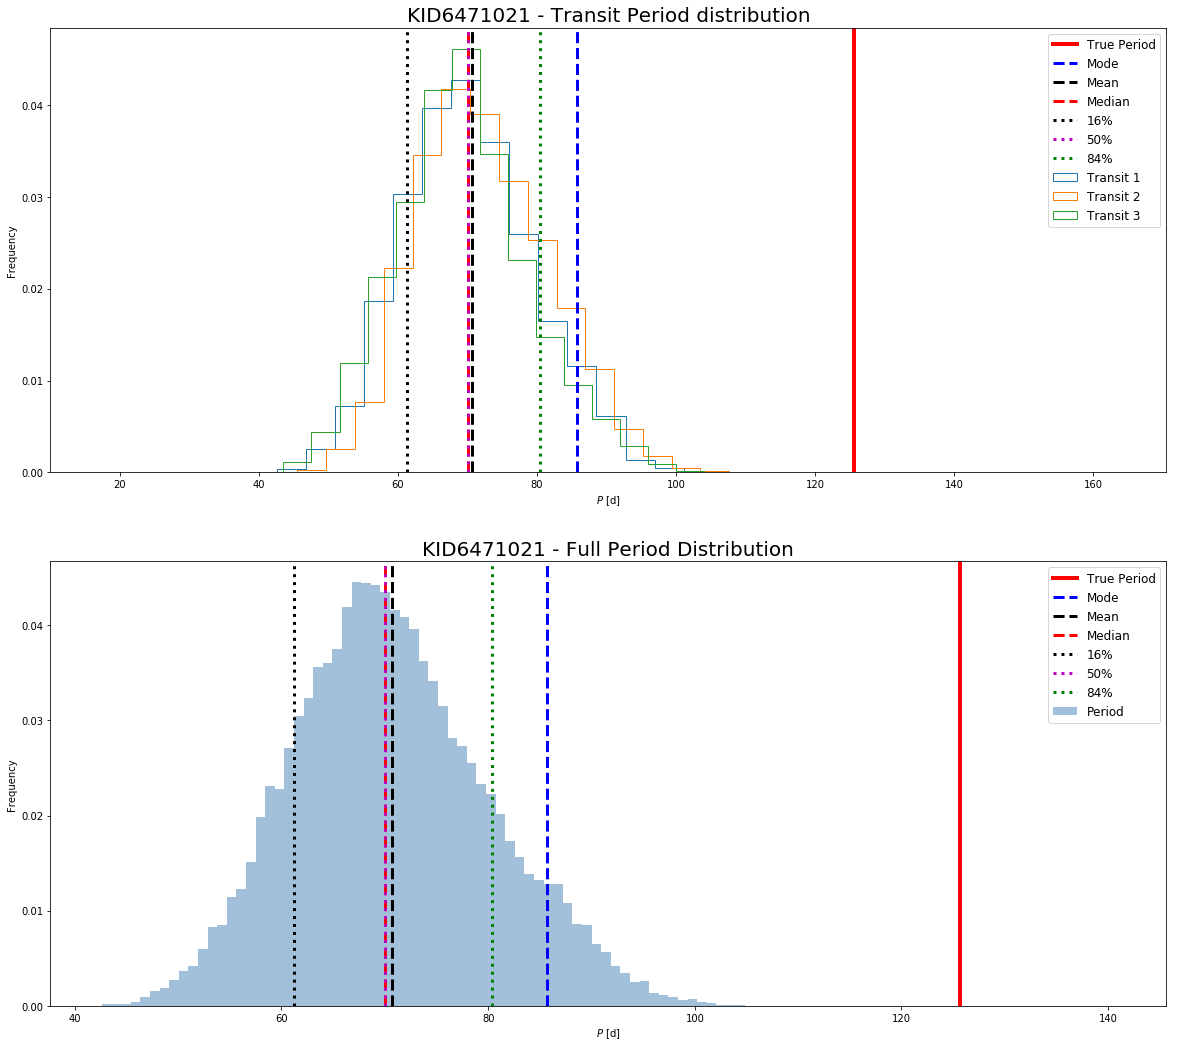

	mean = 70.671655,
	sigma = 9.513008,
	skewness = 0.279229
	and kurtosis = -0.140001


<Figure size 432x288 with 0 Axes>

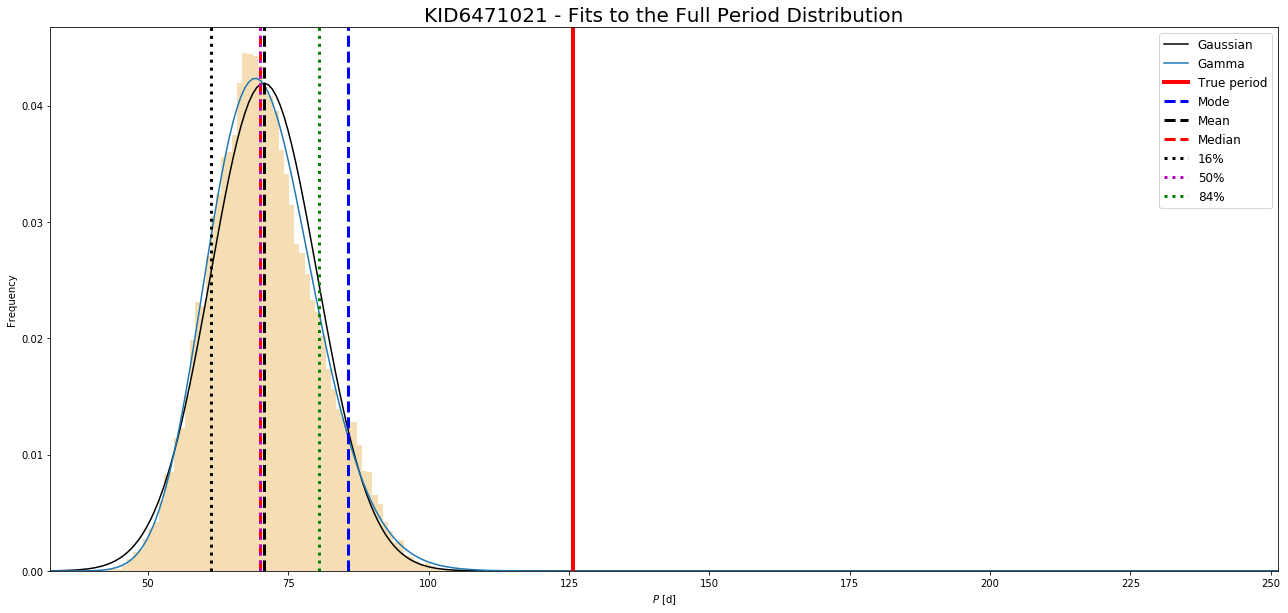

-----------------------KID5164255-----------------------
True period [d]: 15.37562369
Nº of observed trans = 19
Nº of missed trans = 3
Nº of bad or cut-out transits (post-MCMC)  =  1


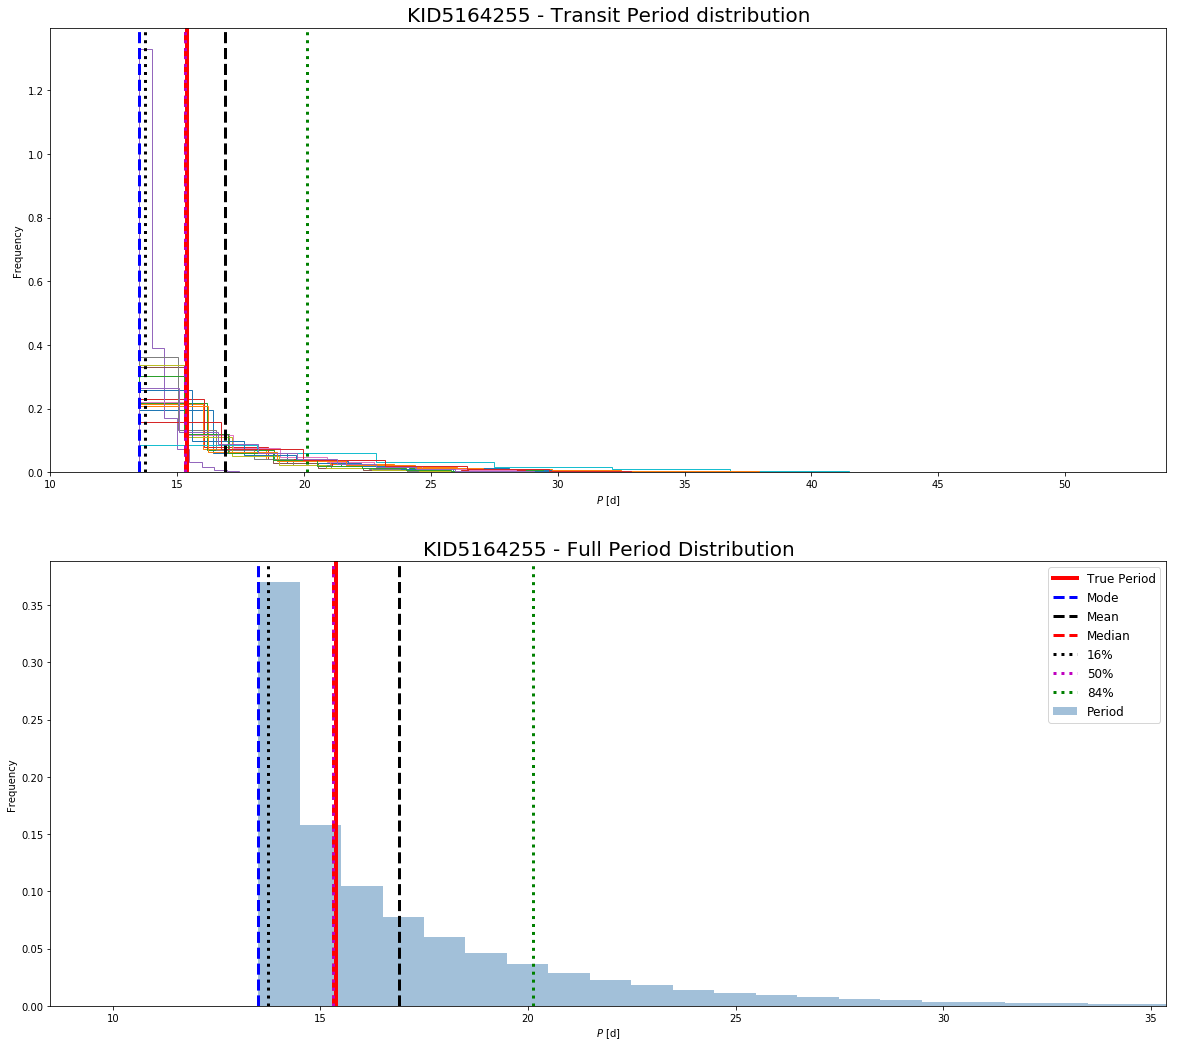

	mean = 16.897532,
	sigma = 4.361848,
	skewness = 2.655533
	and kurtosis = 11.290411


<Figure size 432x288 with 0 Axes>

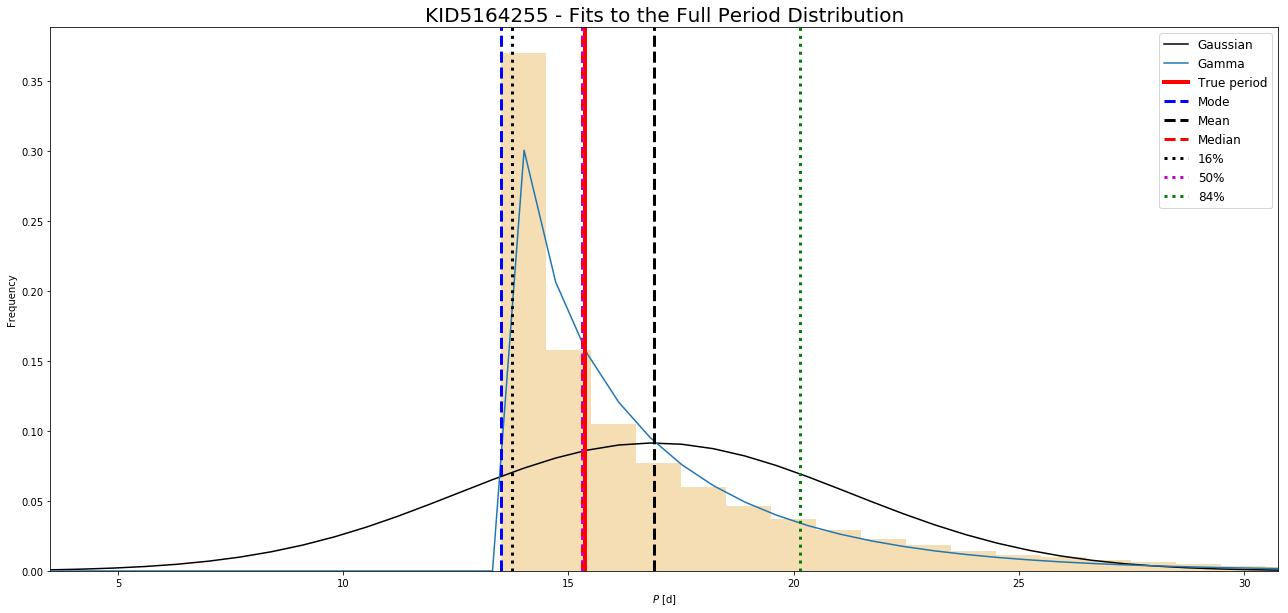

-----------------------KID6707835-----------------------
True period [d]: 22.24814617
Nº of observed trans = 1
Nº of missed trans = 0
Nº of bad or cut-out transits (post-MCMC)  =  0


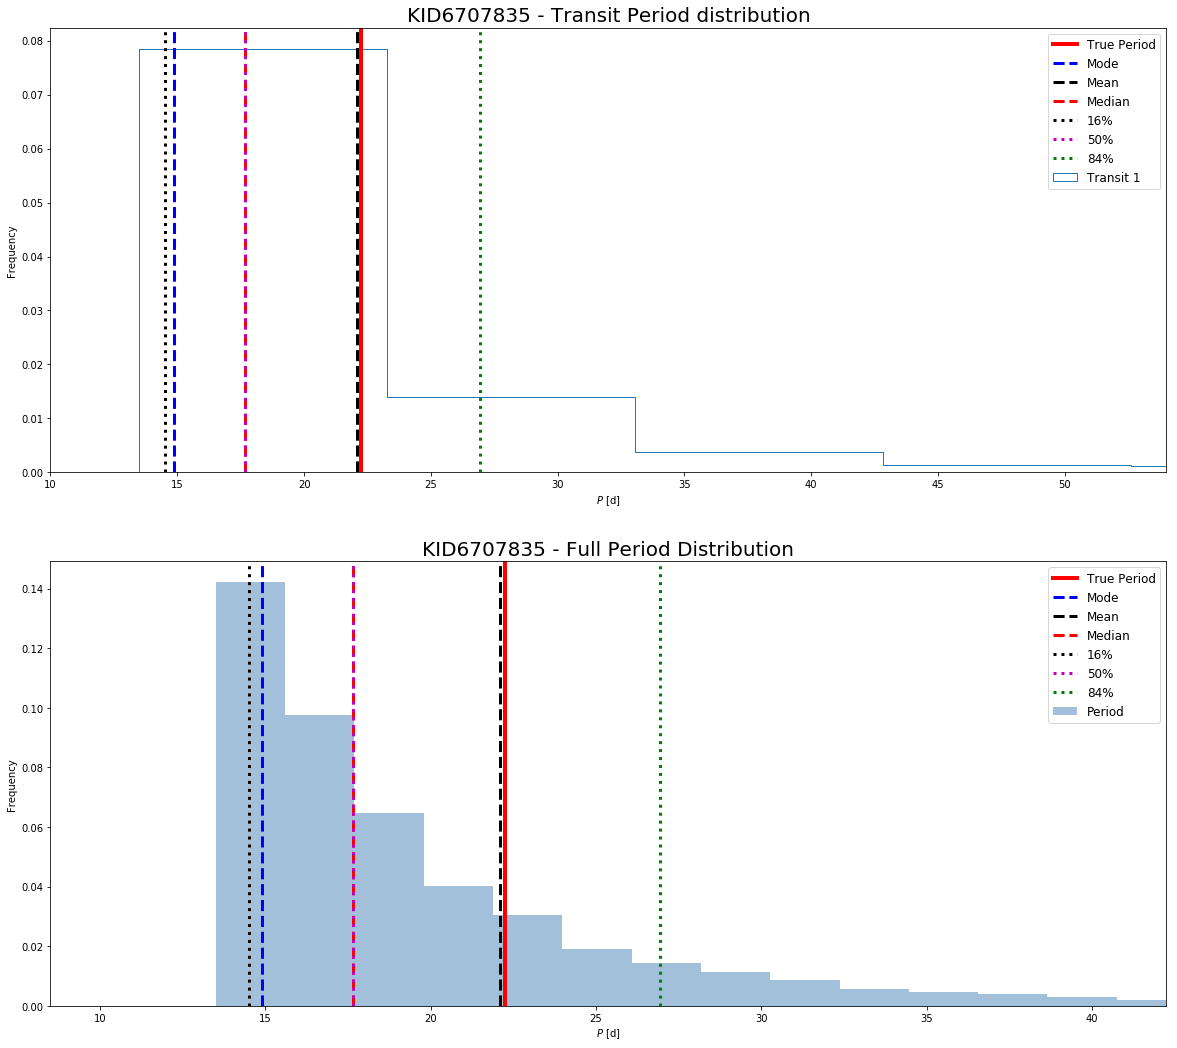

	mean = 22.087289,
	sigma = 13.420907,
	skewness = 3.455830
	and kurtosis = 14.265855


<Figure size 432x288 with 0 Axes>

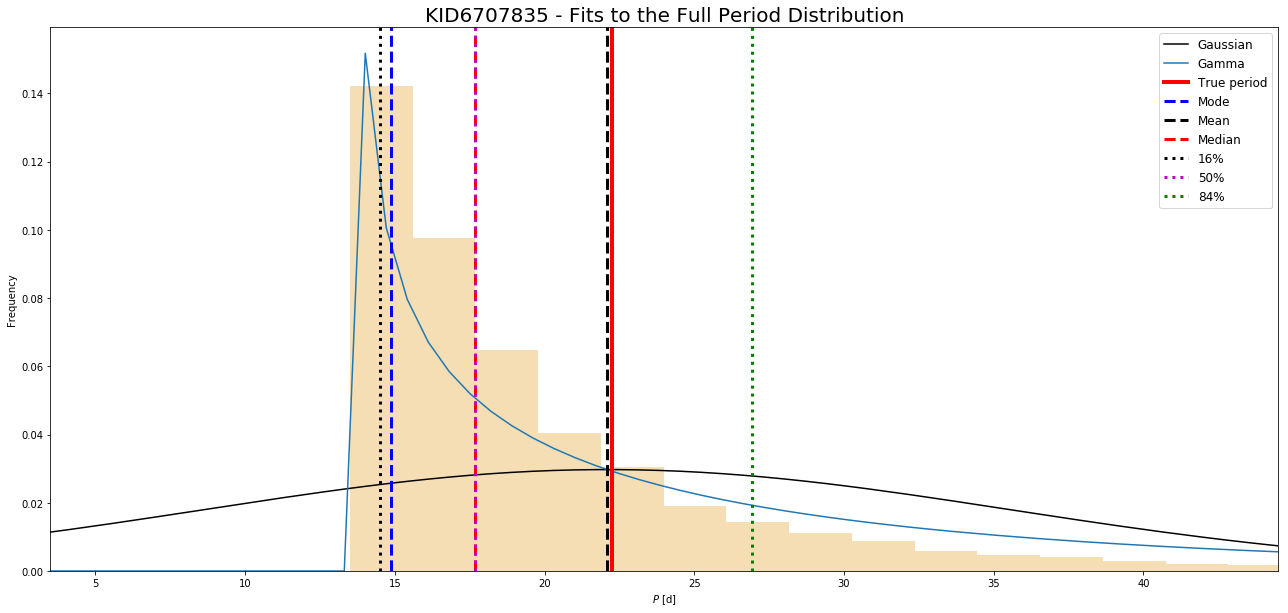

-----------------------KID8686097-----------------------
True period [d]: 172.7046083
Nº of observed trans = 5
Nº of missed trans = 0
Nº of bad or cut-out transits (post-MCMC)  =  1


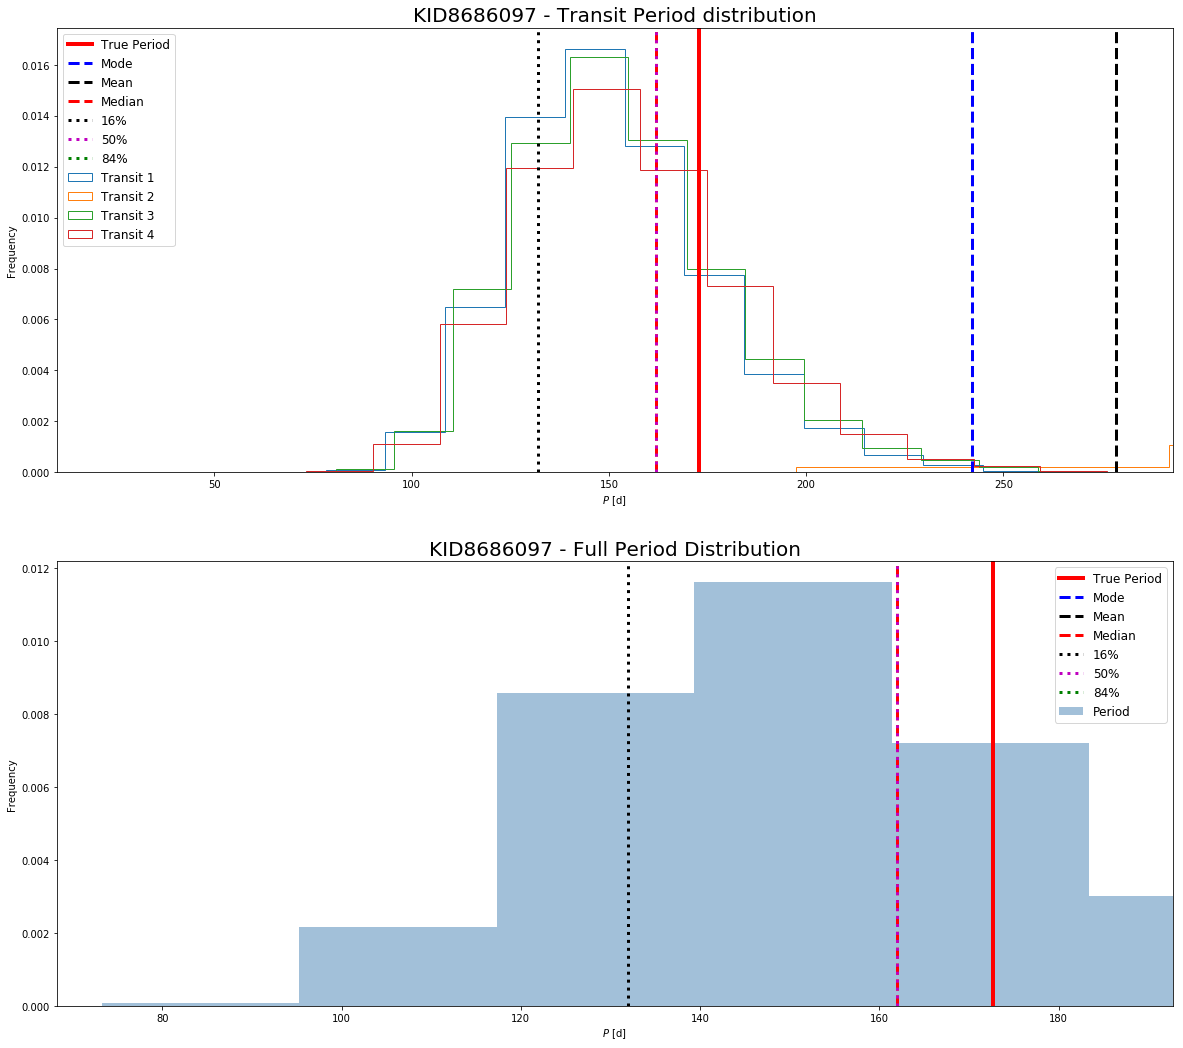

	mean = 278.568916,
	sigma = 245.986090,
	skewness = 1.863450
	and kurtosis = 2.573039


<Figure size 432x288 with 0 Axes>

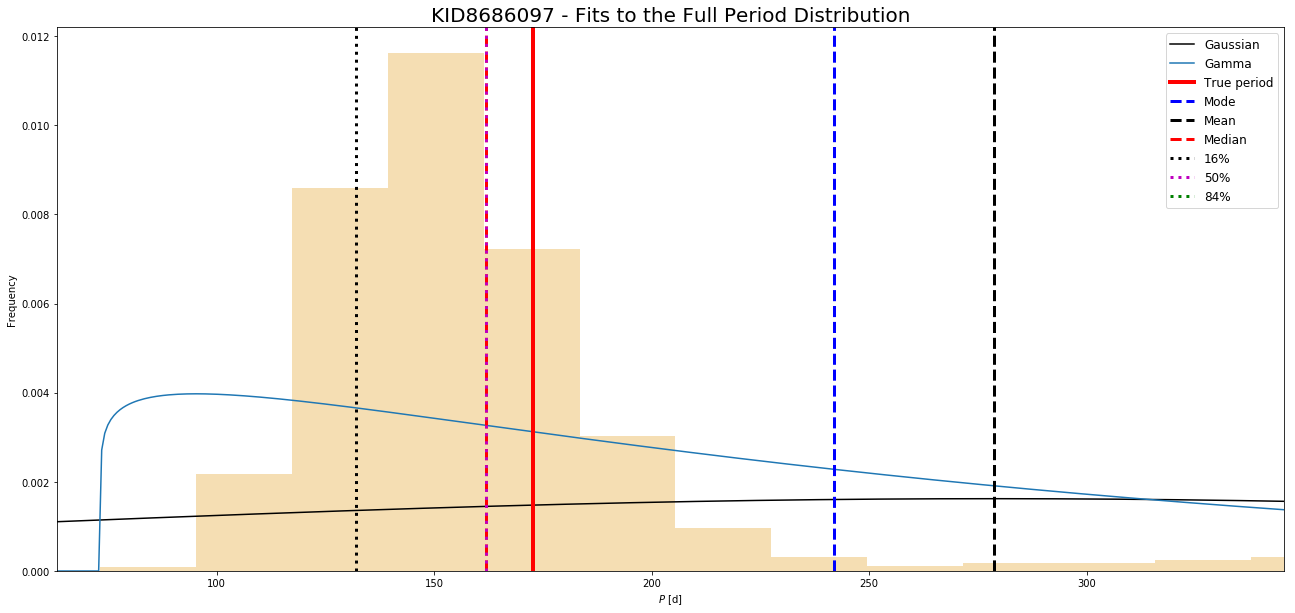

-----------------------KID5966322-----------------------
True period [d]: 60.92818866
Nº of observed trans = 4
Nº of missed trans = 1
Nº of bad or cut-out transits (post-MCMC)  =  2


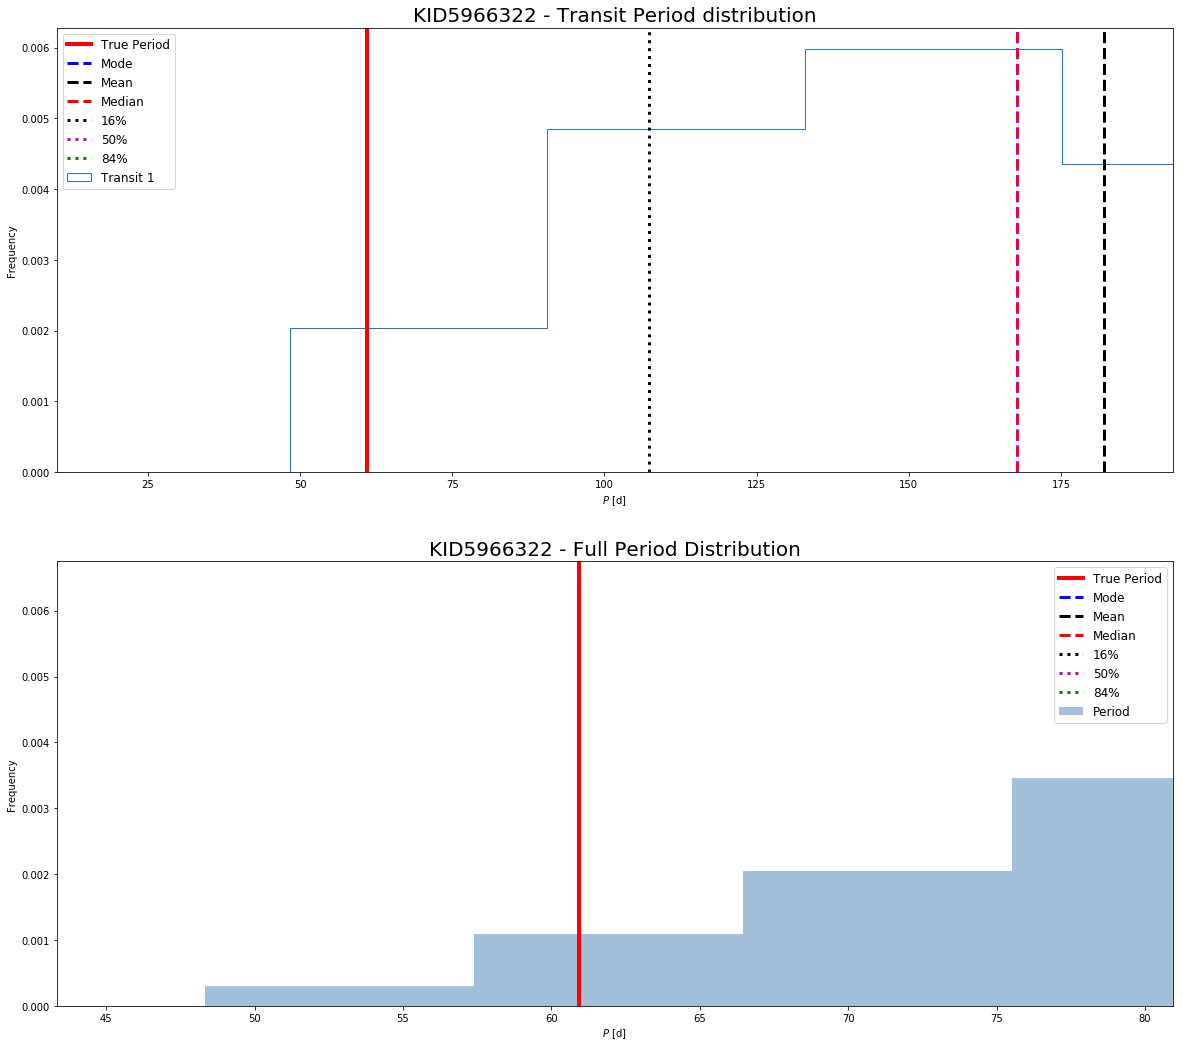

	mean = 182.029157,
	sigma = 78.618968,
	skewness = 1.208583
	and kurtosis = 2.604787


<Figure size 432x288 with 0 Axes>

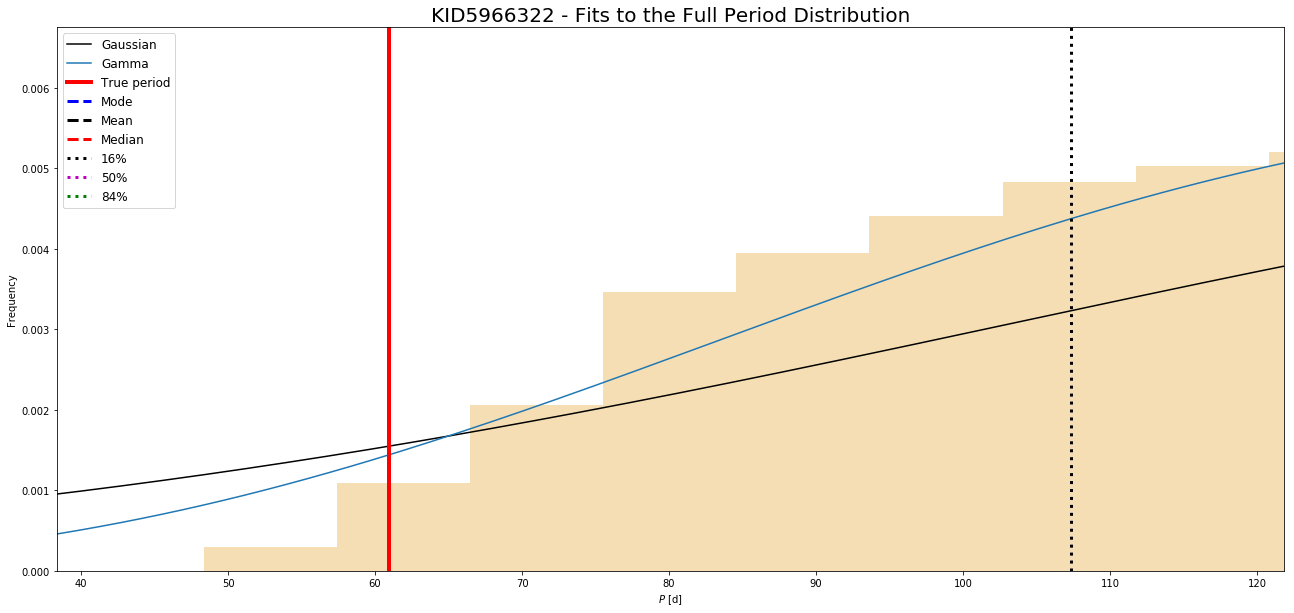

-----------------------KID11015108-----------------------
True period [d]: 39.30944096
Nº of observed trans = 3
Nº of missed trans = 0
Nº of bad or cut-out transits (post-MCMC)  =  0


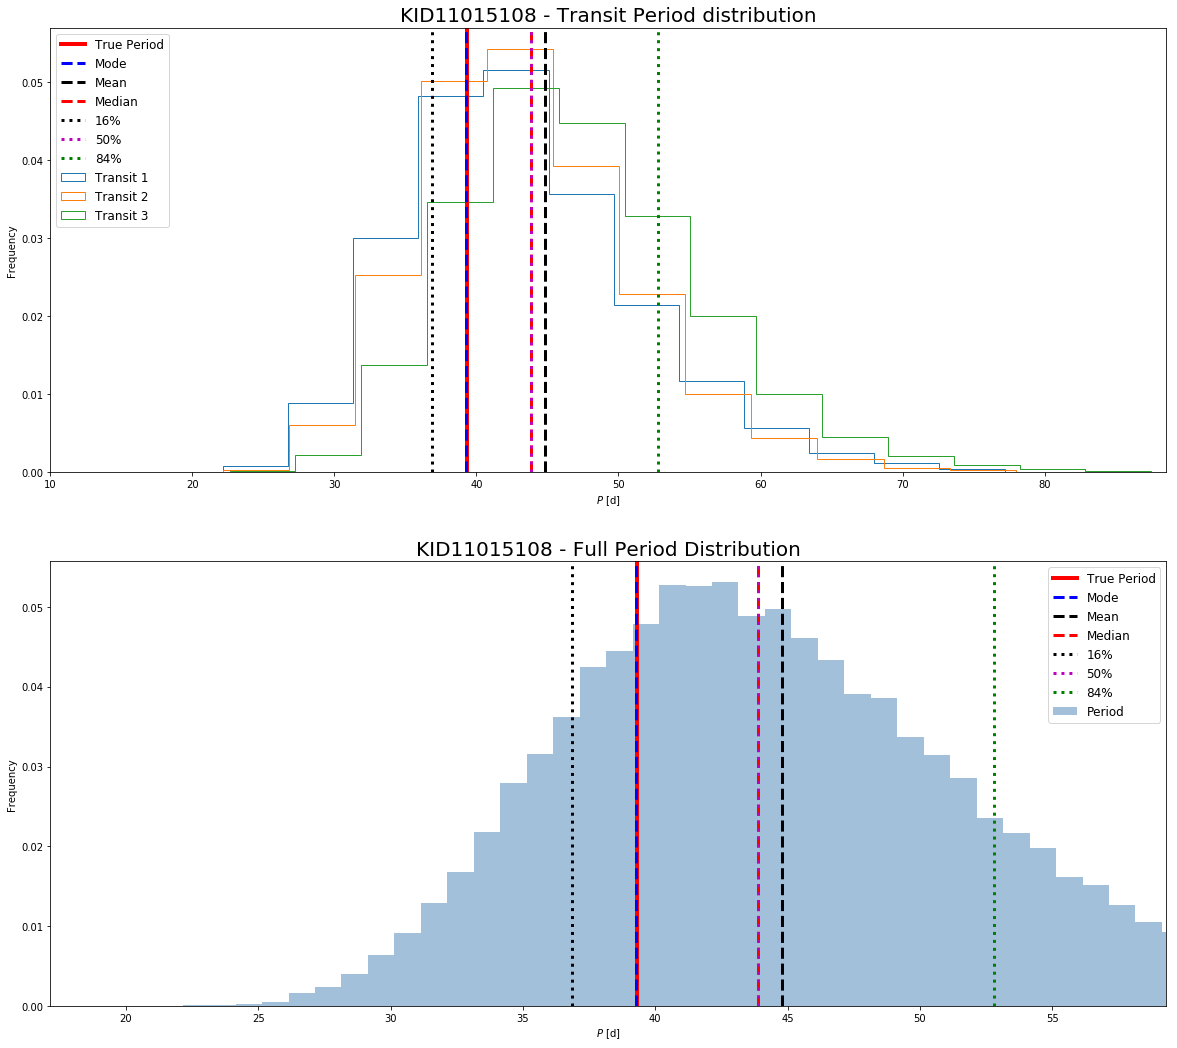

	mean = 44.802148,
	sigma = 8.284351,
	skewness = 0.680004
	and kurtosis = 0.770218


<Figure size 432x288 with 0 Axes>

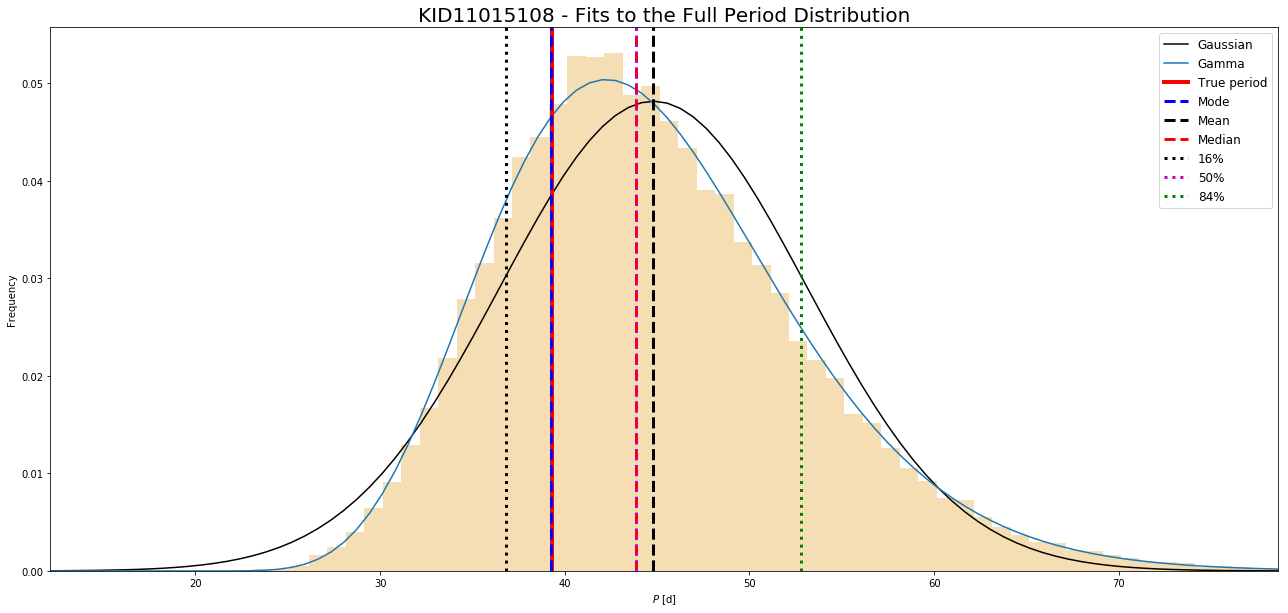

-----------------------KID10593626-----------------------
True period [d]: 289.864067
Nº of observed trans = 5
Nº of missed trans = 2
Nº of bad or cut-out transits (post-MCMC)  =  0


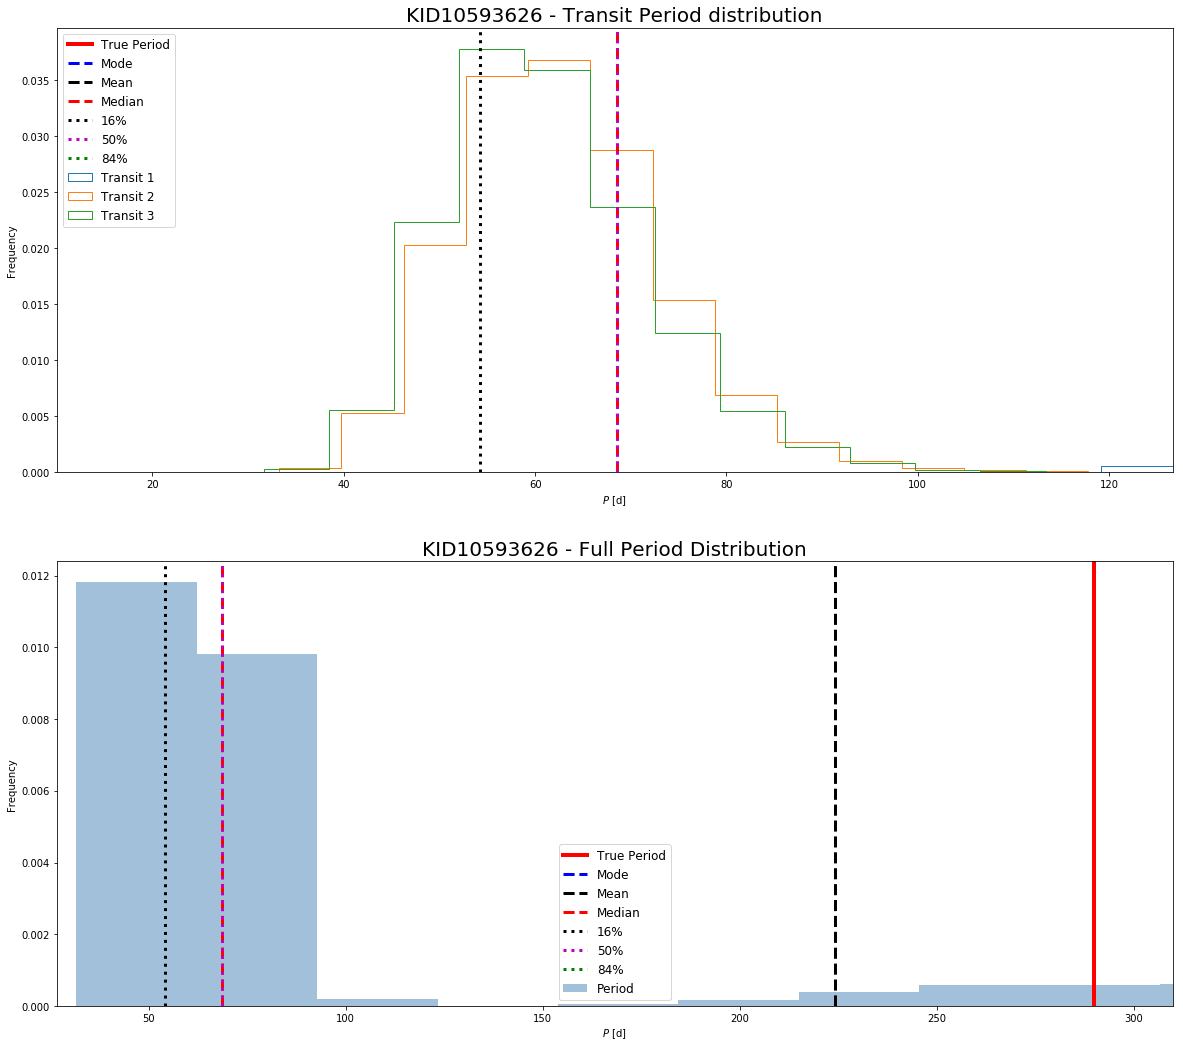

	mean = 224.052899,
	sigma = 274.948242,
	skewness = 1.894381
	and kurtosis = 3.826414


<Figure size 432x288 with 0 Axes>

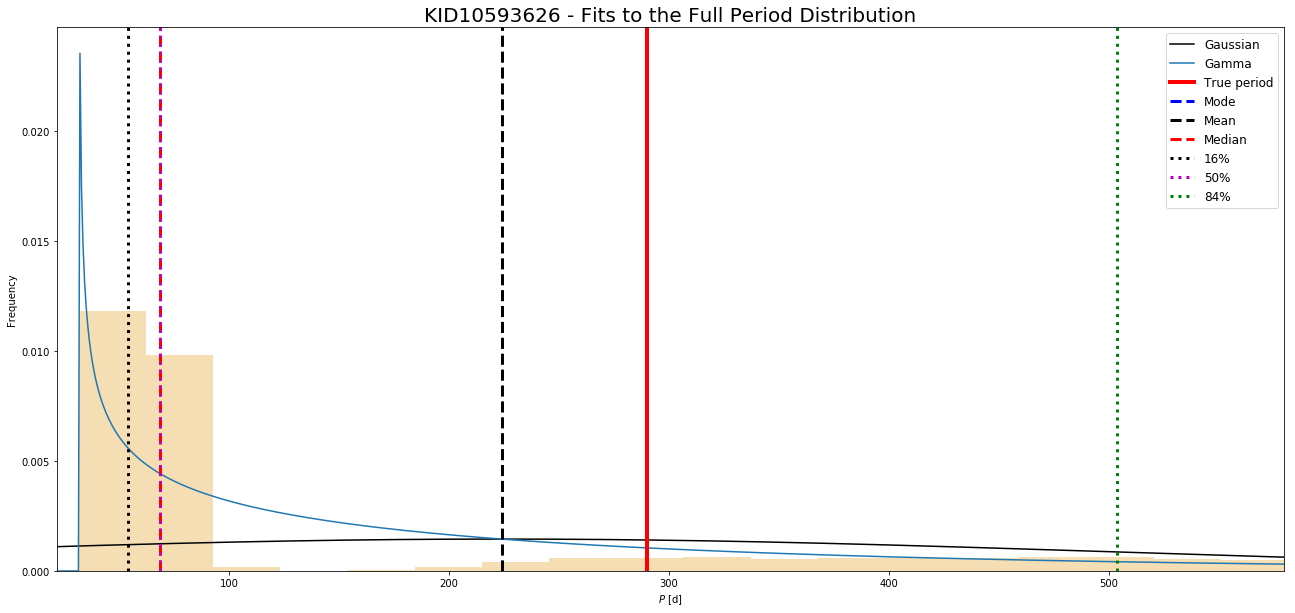

-----------------------KID3835670-----------------------
True period [d]: 14.55730897
Nº of observed trans = 38
Nº of missed trans = 5
Nº of bad or cut-out transits (post-MCMC)  =  9


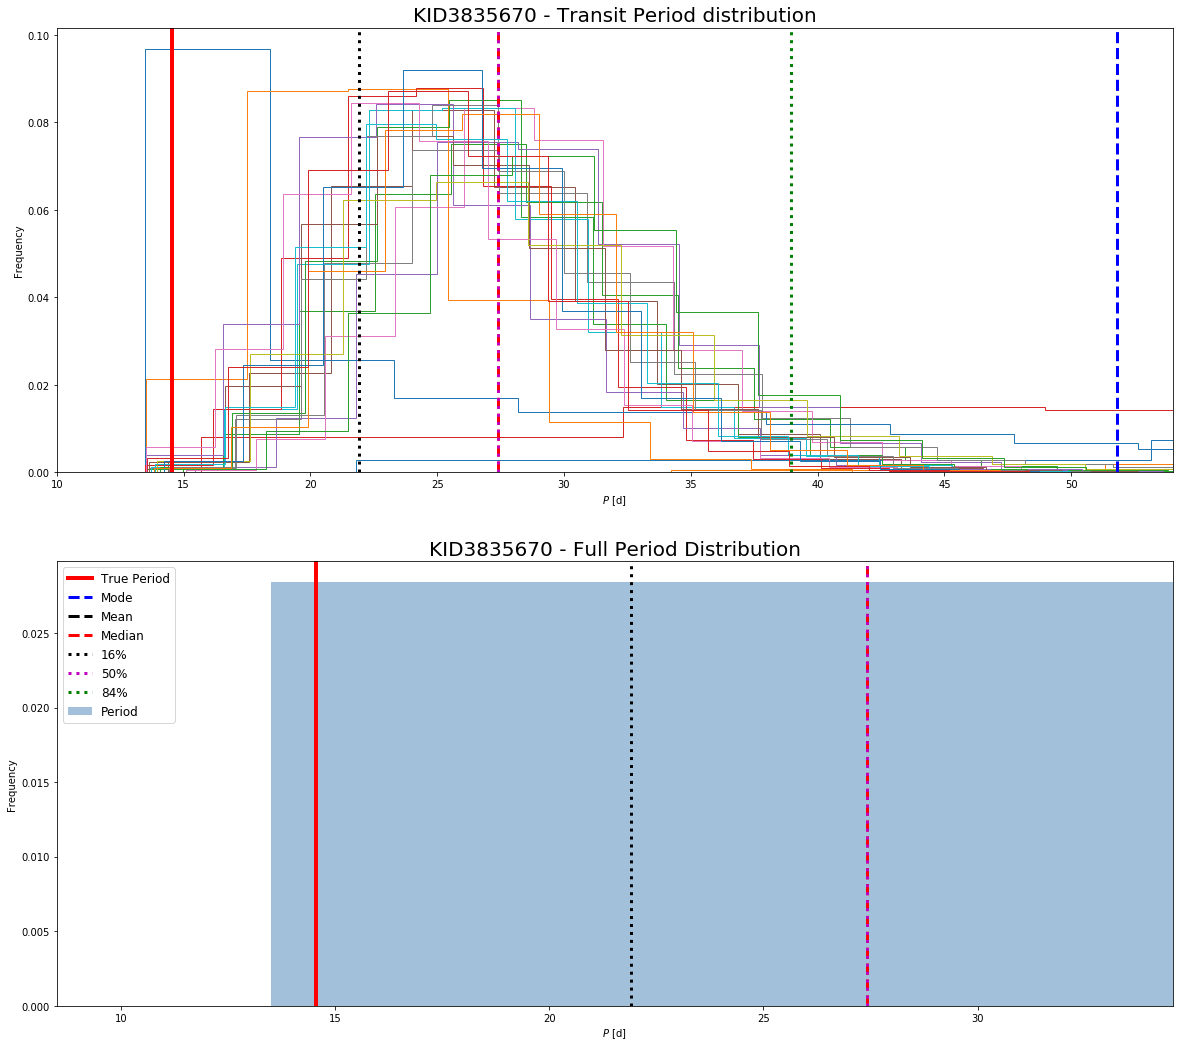

	mean = 57.337943,
	sigma = 129.465163,
	skewness = 6.259473
	and kurtosis = 48.155269


<Figure size 432x288 with 0 Axes>

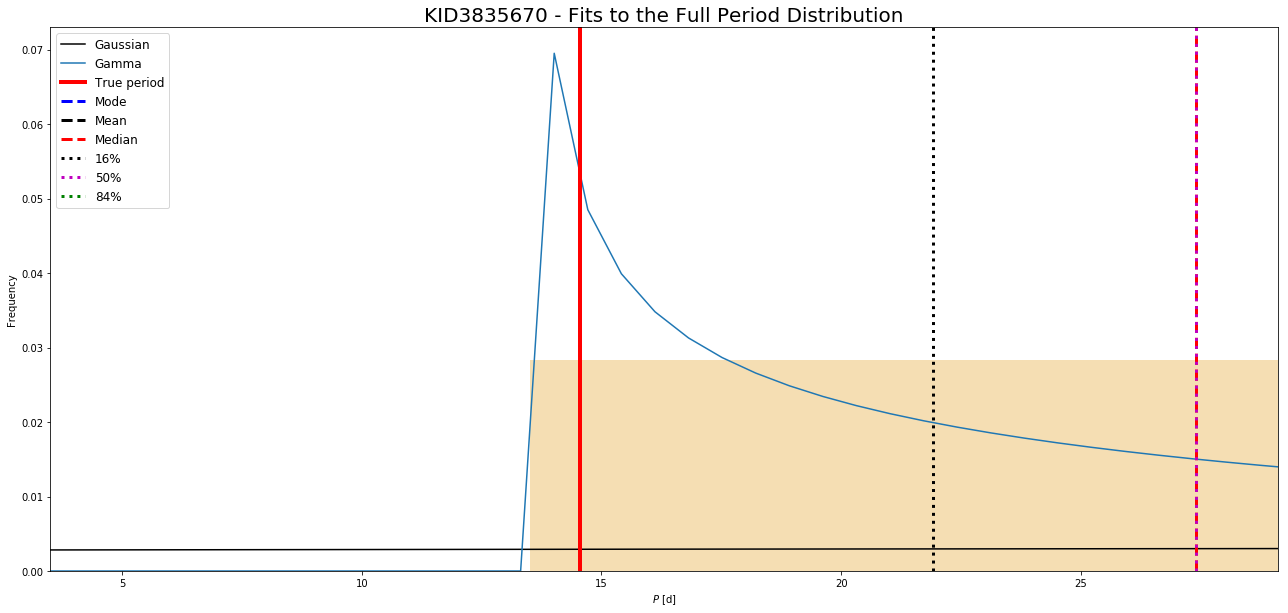

-----------------------KID8950853-----------------------
True period [d]: 37.8145252
Nº of observed trans = 1
Nº of missed trans = 0
Nº of bad or cut-out transits (post-MCMC)  =  0


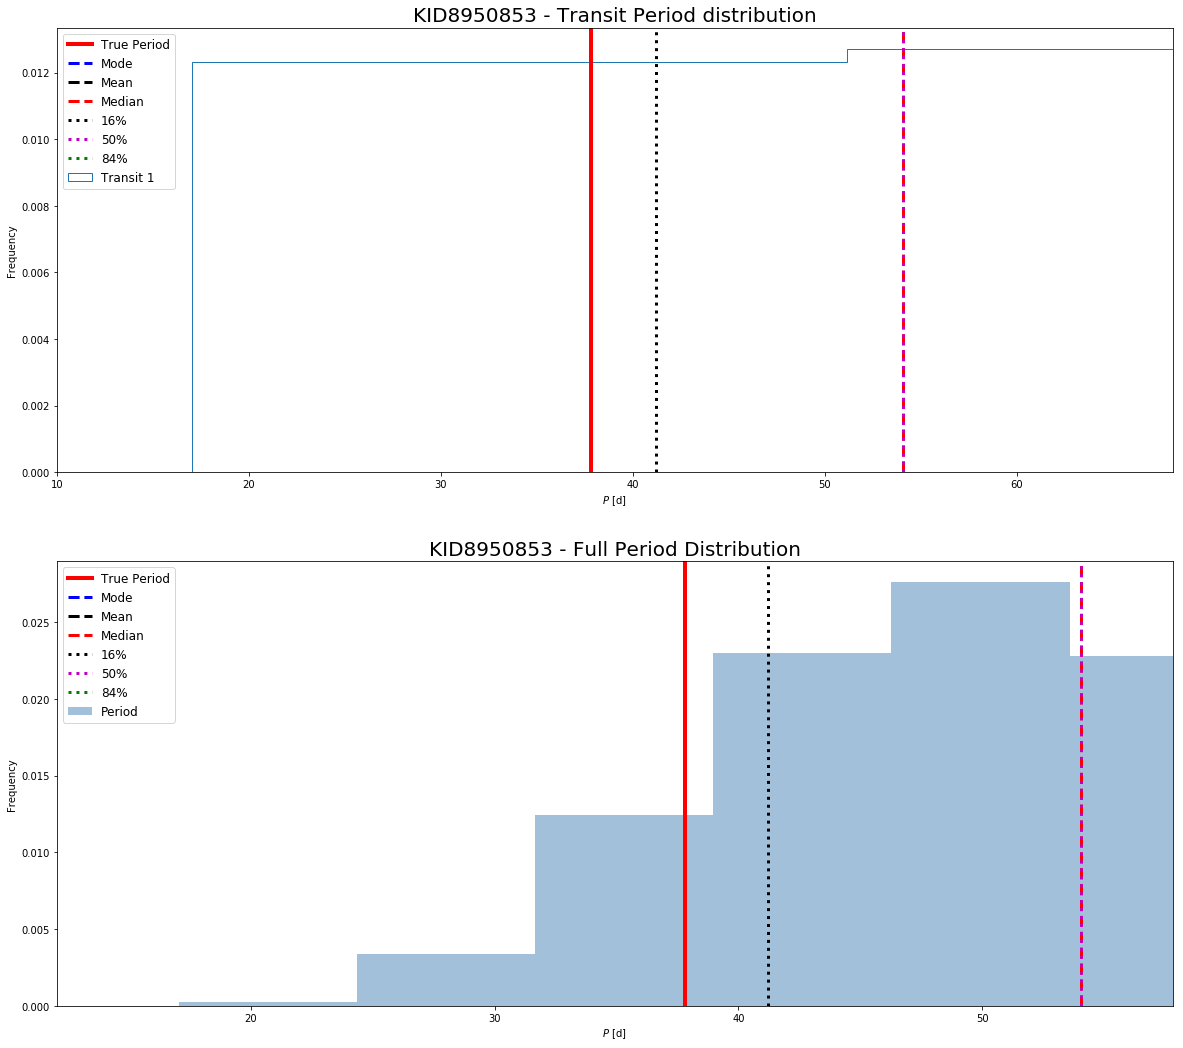

	mean = 75.241782,
	sigma = 63.339095,
	skewness = 2.523320
	and kurtosis = 5.491438


<Figure size 432x288 with 0 Axes>

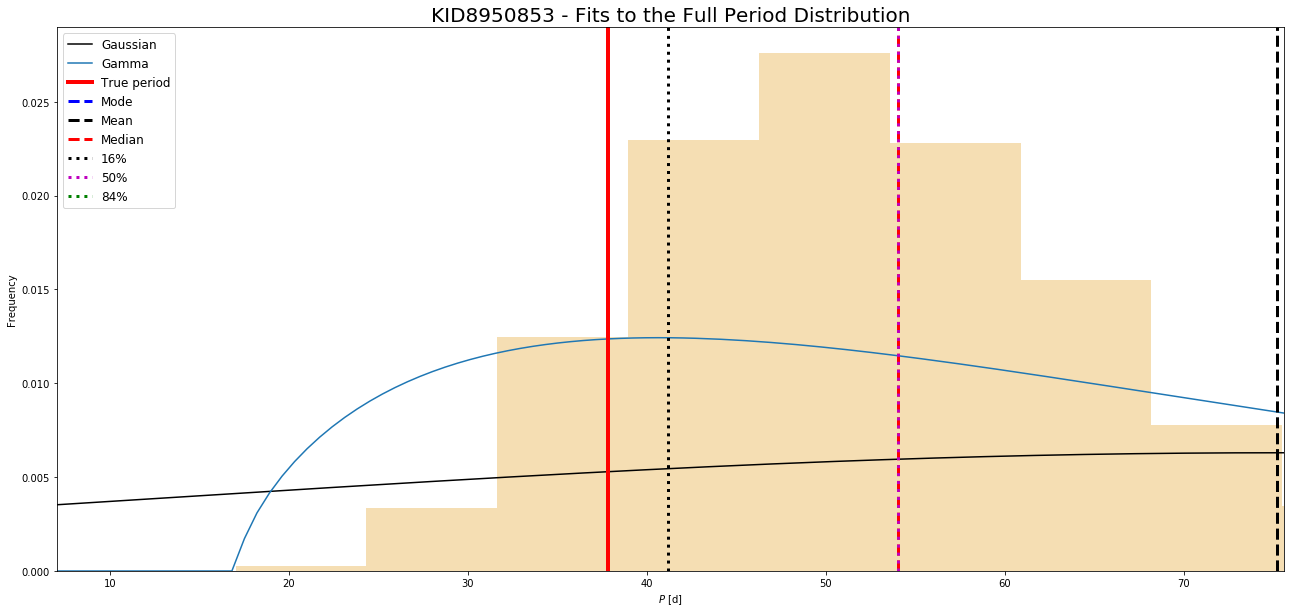

-----------------------KID3859079-----------------------
True period [d]: 53.5292702
Nº of observed trans = 11
Nº of missed trans = 3
Nº of bad or cut-out transits (post-MCMC)  =  2


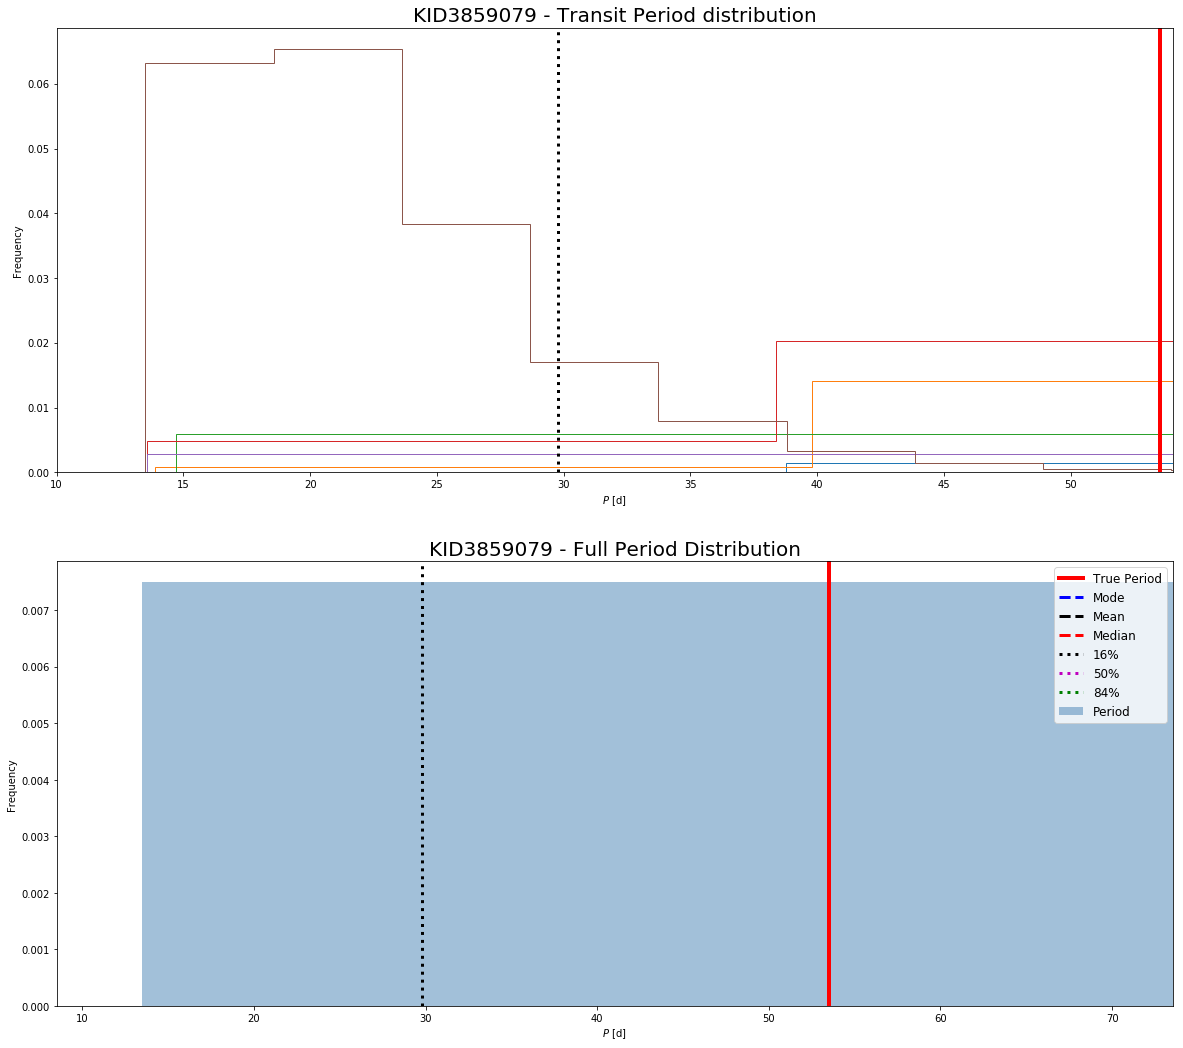

	mean = 158.816716,
	sigma = 246.735747,
	skewness = 4.660329
	and kurtosis = 32.402005


<Figure size 432x288 with 0 Axes>

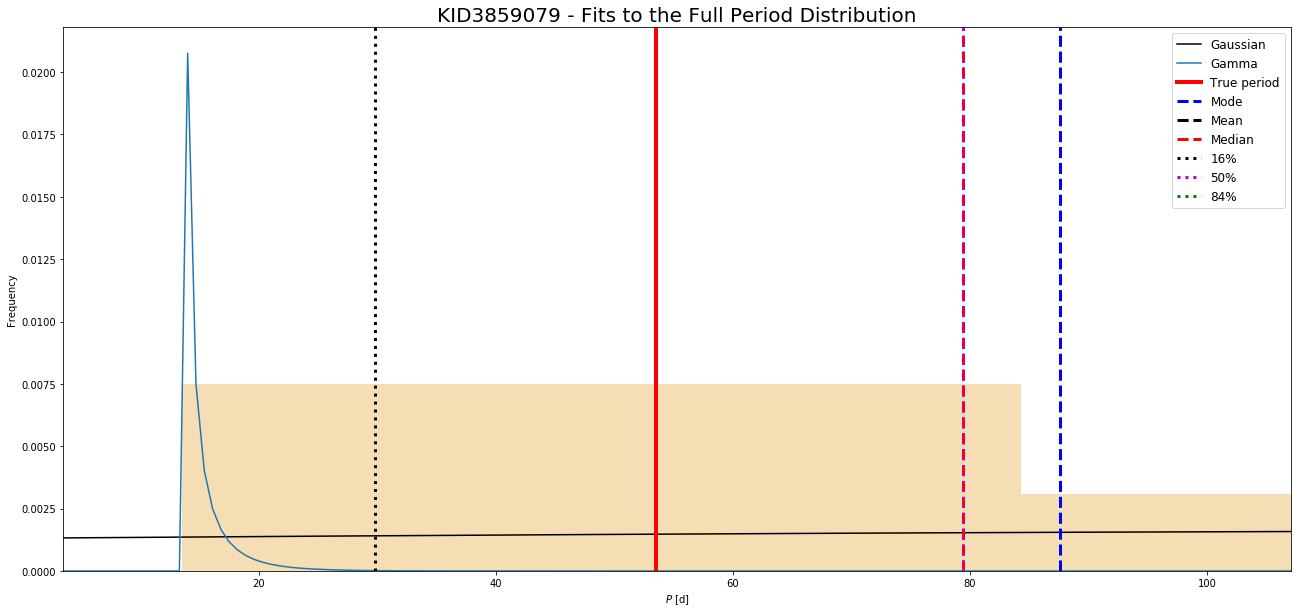

-----------------------KID4155328-----------------------
True period [d]: 127.8334997
Nº of observed trans = 1
Nº of missed trans = 0
Nº of bad or cut-out transits (post-MCMC)  =  0


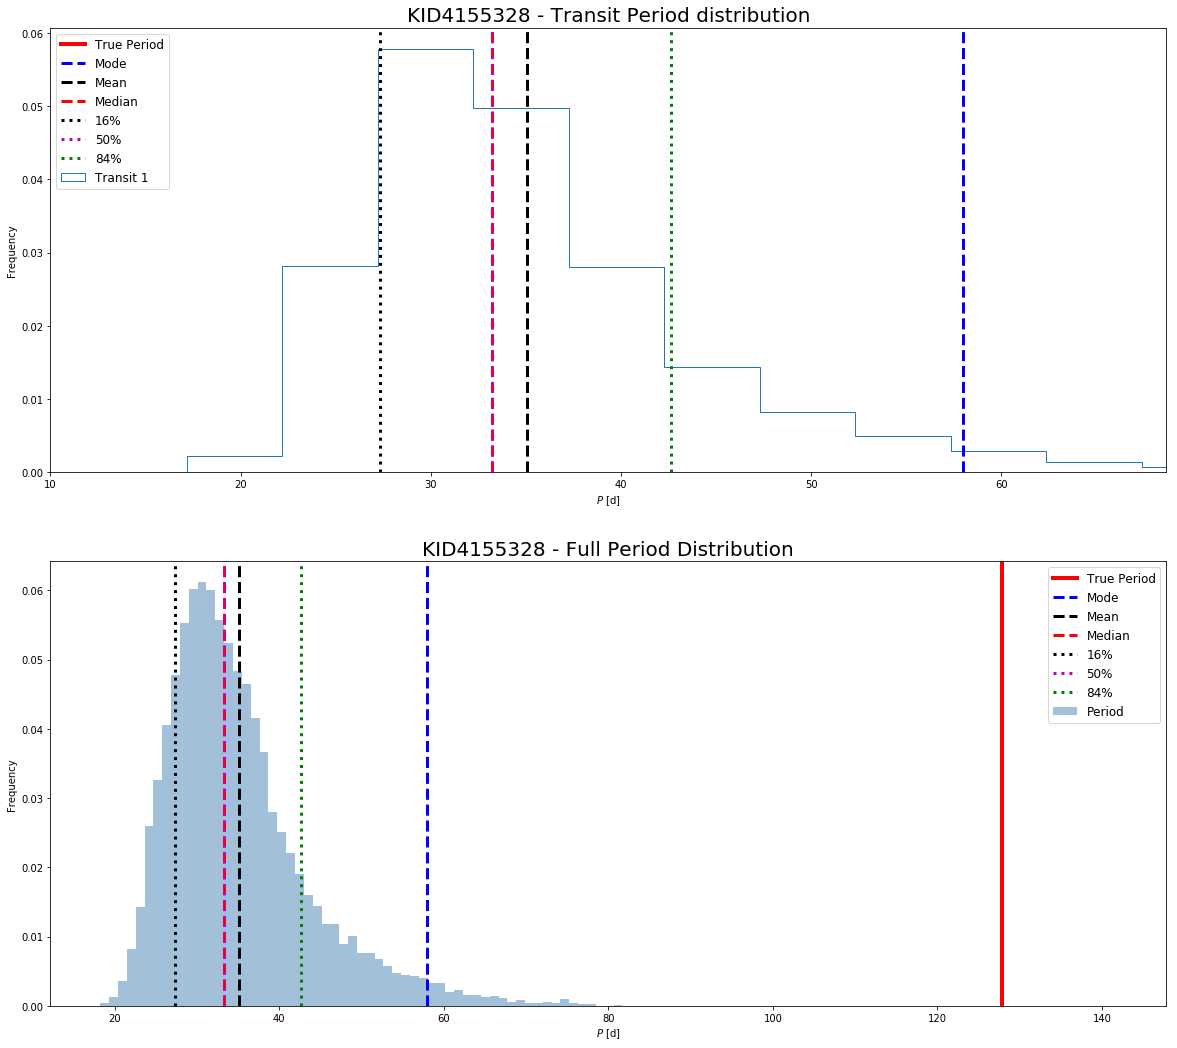

	mean = 35.084978,
	sigma = 8.809733,
	skewness = 1.373726
	and kurtosis = 2.596658


<Figure size 432x288 with 0 Axes>

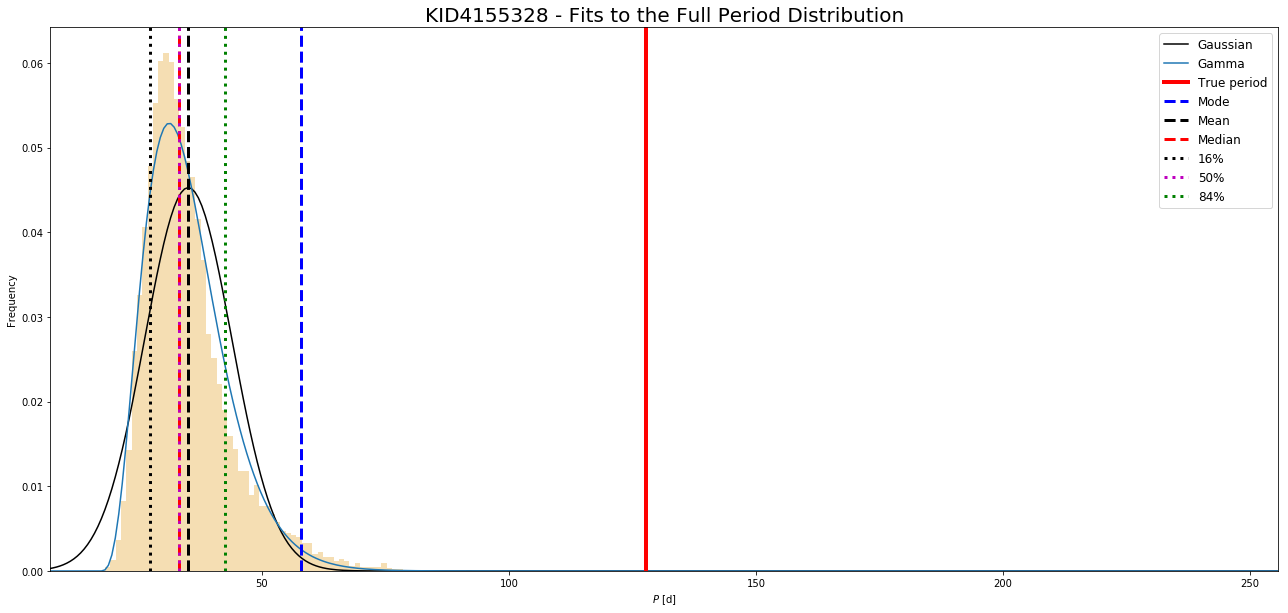

-----------------------KID4841374-----------------------
True period [d]: 161.4746786
Nº of observed trans = 1
Nº of missed trans = 0
Nº of bad or cut-out transits (post-MCMC)  =  0


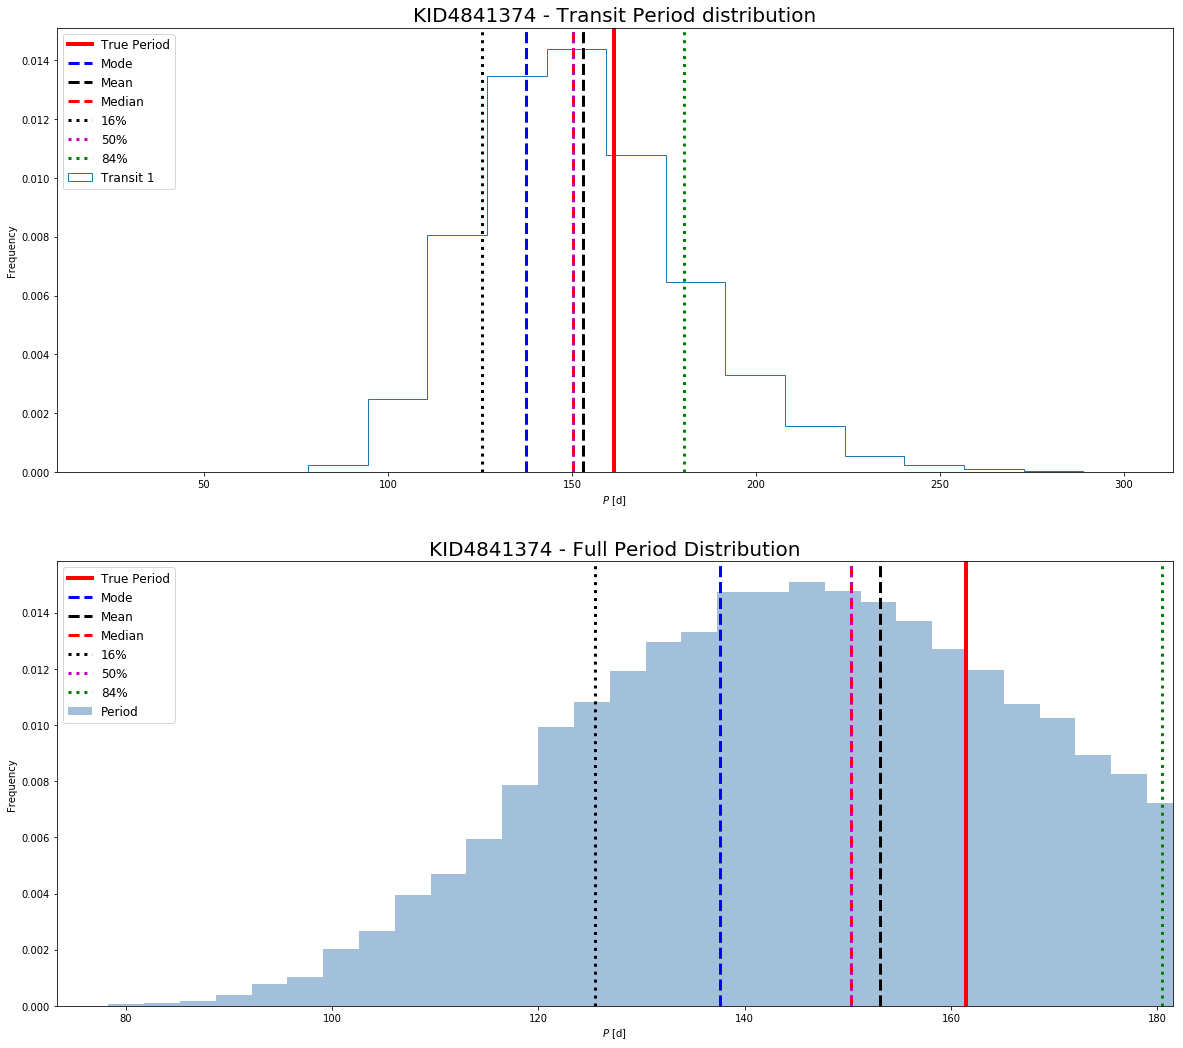

	mean = 153.137887,
	sigma = 28.308421,
	skewness = 0.641858
	and kurtosis = 0.734467


<Figure size 432x288 with 0 Axes>

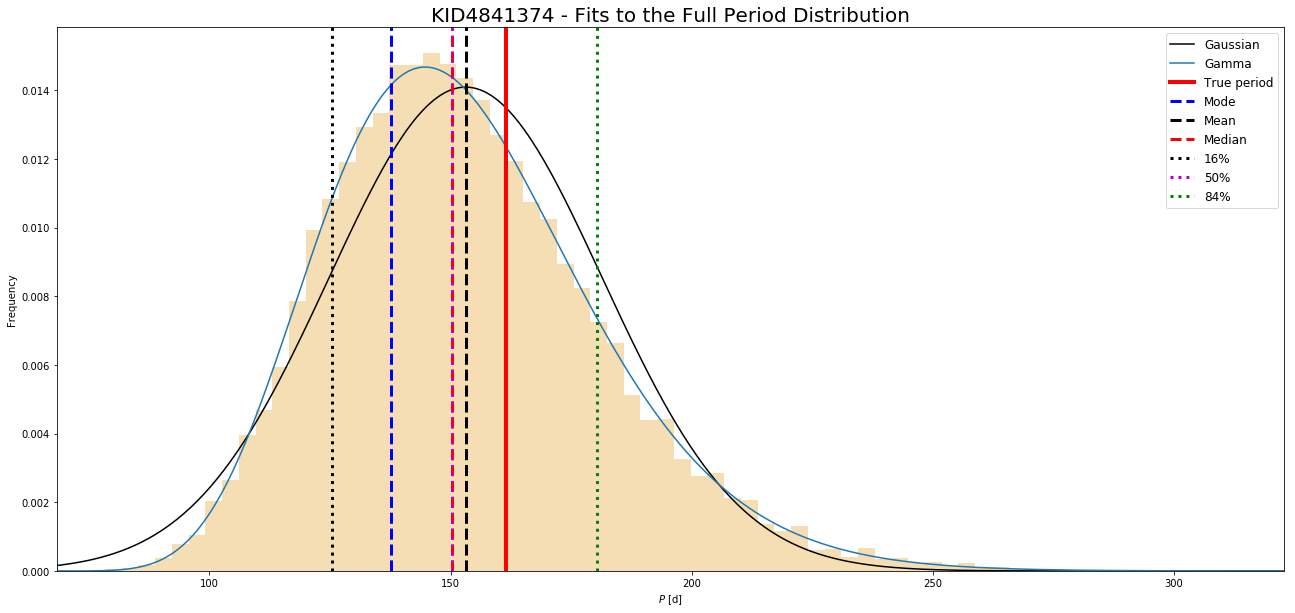

-----------------------KID11074541-----------------------
True period [d]: 29.88487723
Nº of observed trans = 35
Nº of missed trans = 30
Nº of bad or cut-out transits (post-MCMC)  =  2


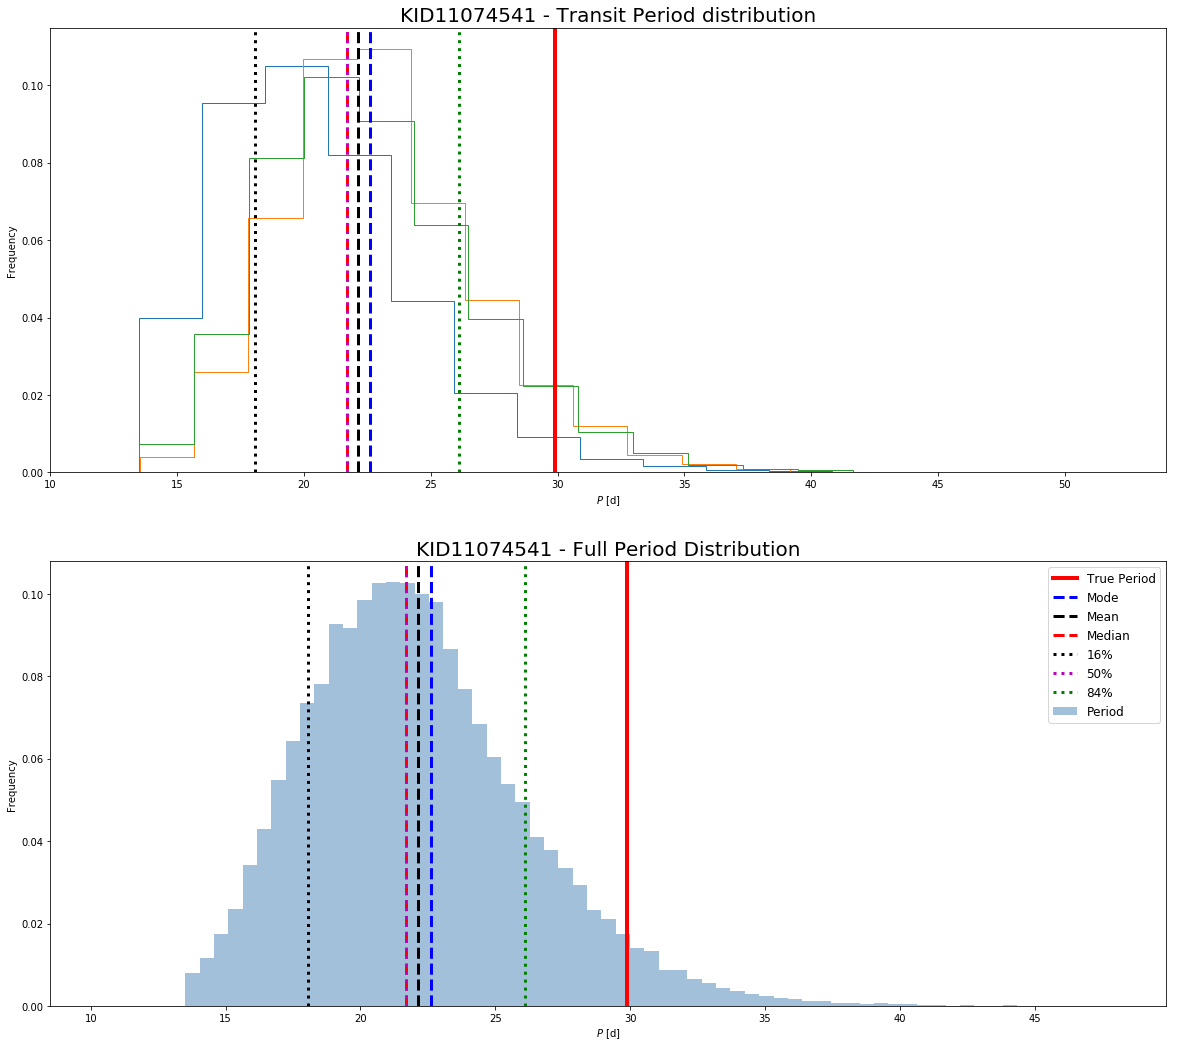

	mean = 22.121043,
	sigma = 4.141993,
	skewness = 0.727456
	and kurtosis = 0.984958


<Figure size 432x288 with 0 Axes>

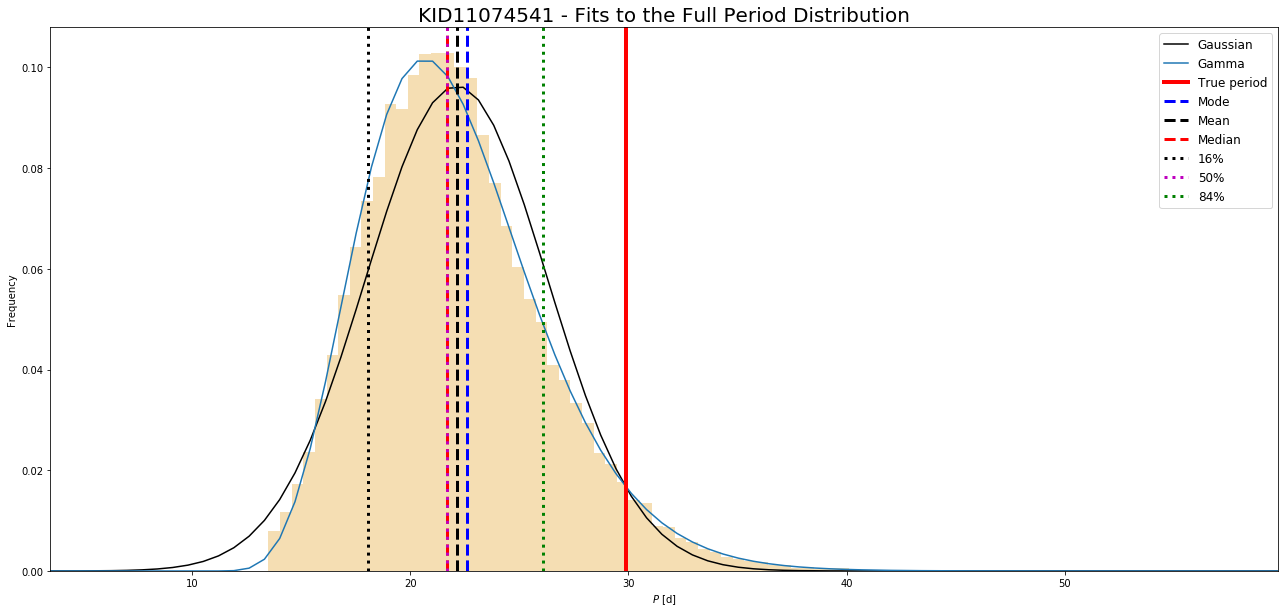

-----------------------KID10528068-----------------------
True period [d]: 158.6850022
Nº of observed trans = 1
Nº of missed trans = 0
Nº of bad or cut-out transits (post-MCMC)  =  0


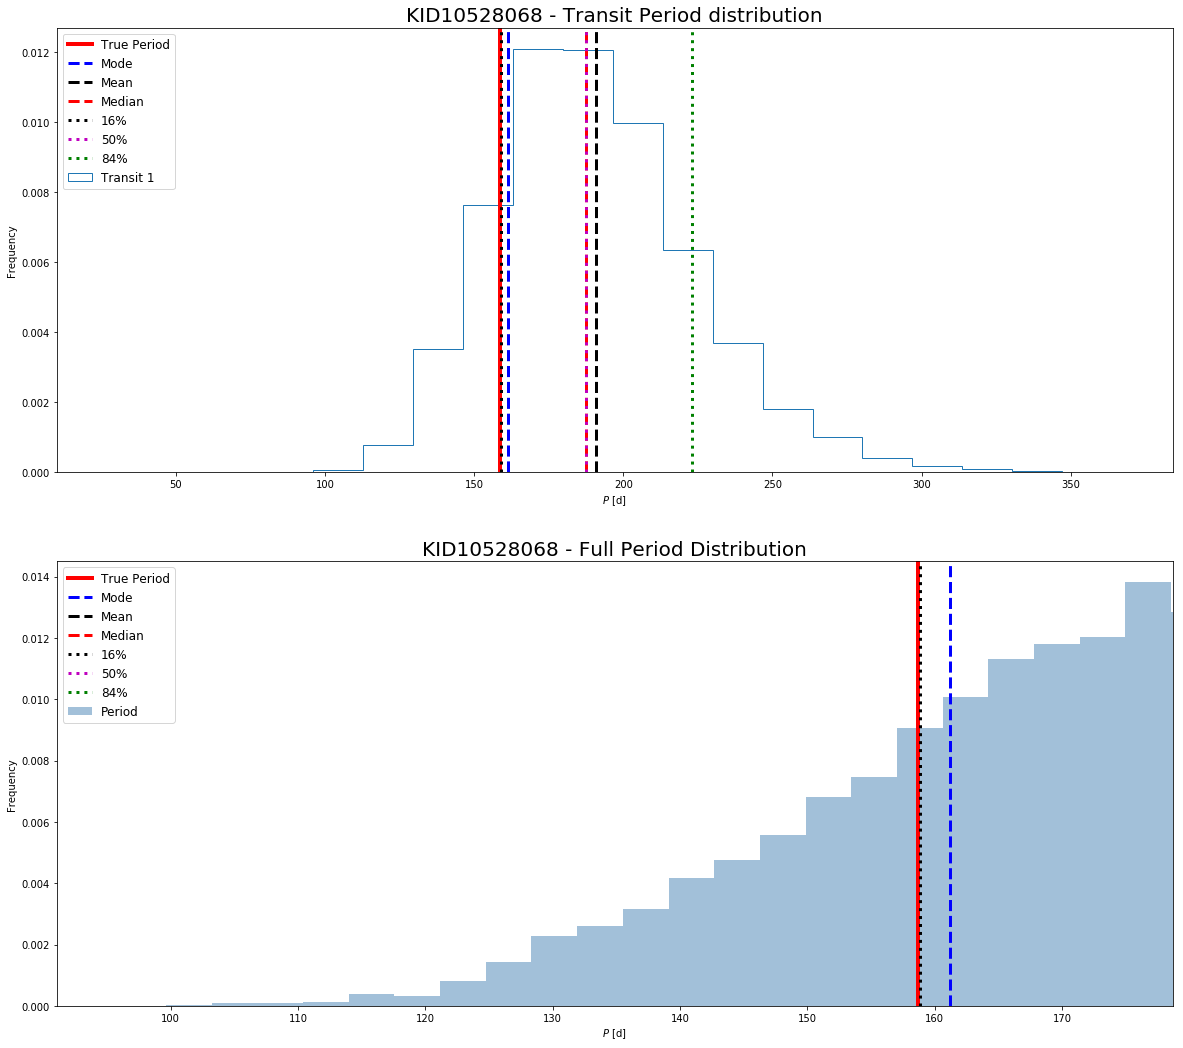

	mean = 190.864962,
	sigma = 33.490585,
	skewness = 0.618127
	and kurtosis = 0.684193


<Figure size 432x288 with 0 Axes>

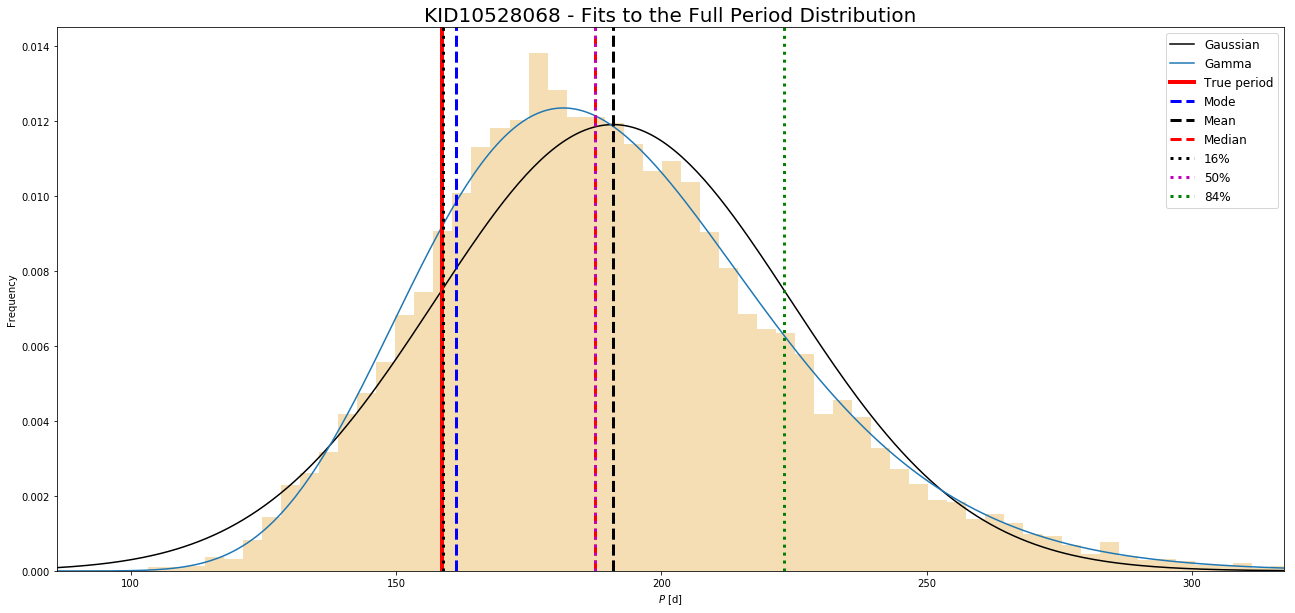

-----------------------KID6504954-----------------------
True period [d]: 130.3543929
Nº of observed trans = 2
Nº of missed trans = 0
Nº of bad or cut-out transits (post-MCMC)  =  0


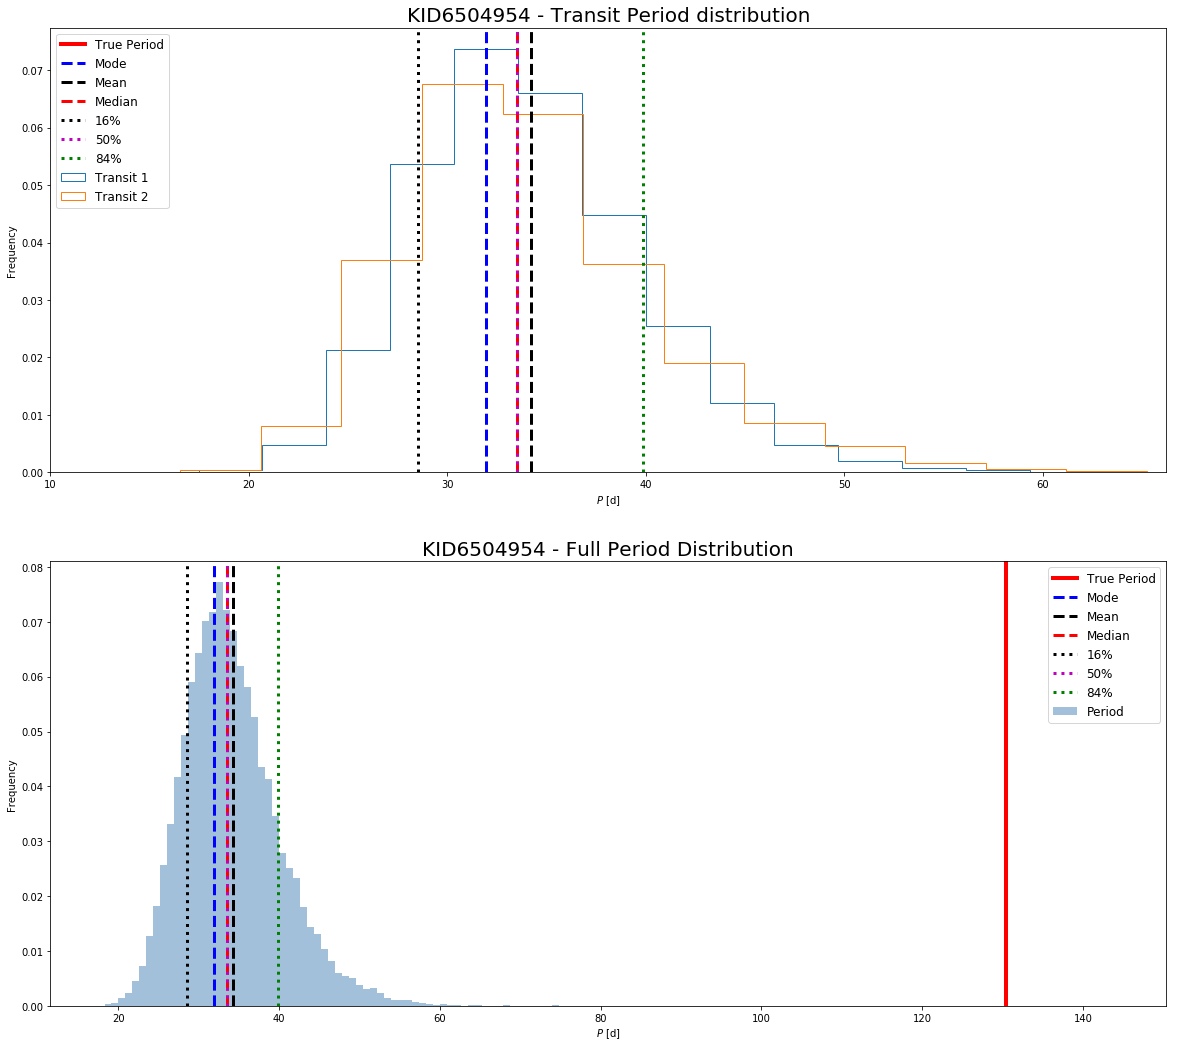

	mean = 34.213055,
	sigma = 6.075936,
	skewness = 0.861380
	and kurtosis = 1.820229


<Figure size 432x288 with 0 Axes>

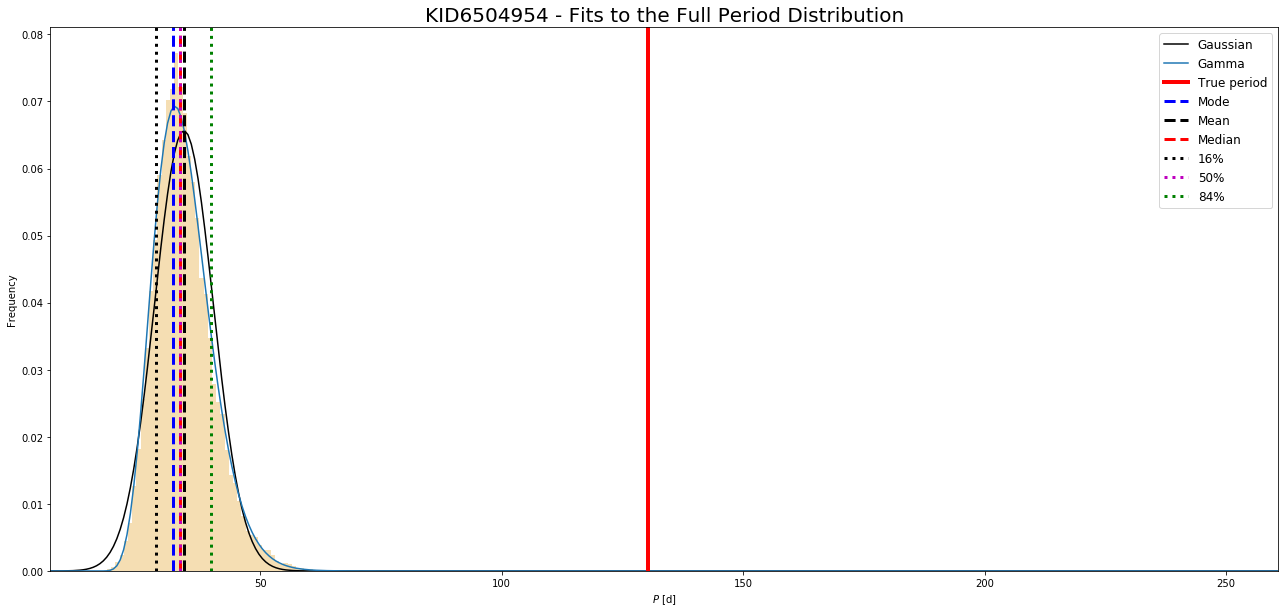

-----------------------KID5812701-----------------------
True period [d]: 17.855221681
Nº of observed trans = 82
Nº of missed trans = 12
Nº of bad or cut-out transits (post-MCMC)  =  5


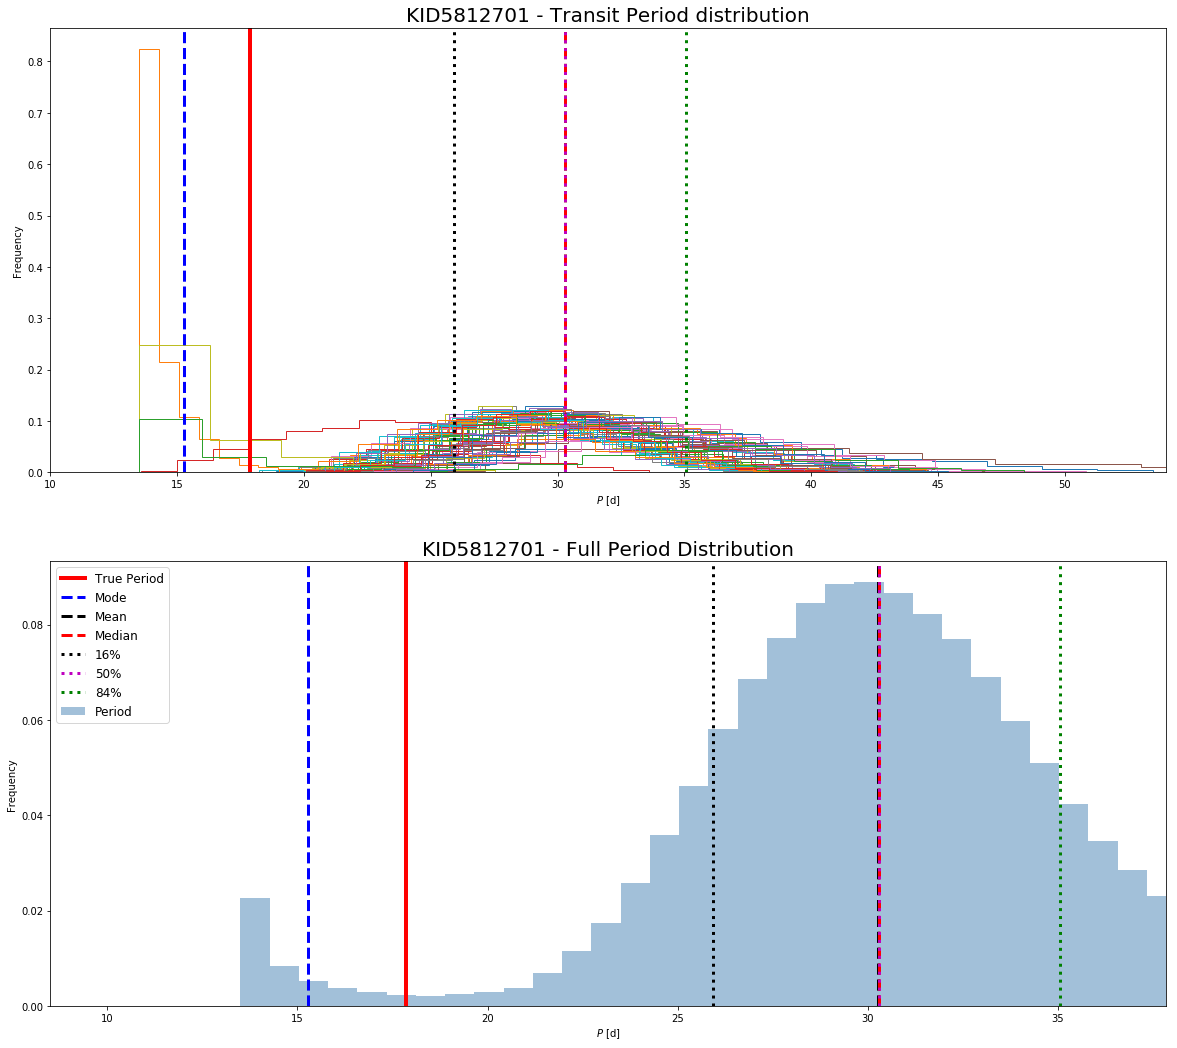

In [ ]:
path = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_distributions/'
mask_factor = 2
ugly_stars = {2853093, 3531558, 3733628, 4143755, 5009743, 5121511, 5383248,
             5796675, 6442377, 7277317, 8107380, 8802165, 8845205, 8866102,
              9578686, 10864656, 11133306, 11259686, 11802615}

stars_wo_transit = {10795103, 8805348, 12365184, 7761545, 11622600, 11027624}

for target in targets:
    if (target.kepid not in ugly_stars) and (target.kepid not in stars_wo_transit):
        print("-----------------------KID"+str(target.kepid)+"-----------------------")
        plt.close('all')
        period_distribution = []
        P_trans_stats = []
        missed_trans = set(target.ind_missed_transits)
        up_bound = mask_factor*target.P
        print("True period [d]:", target.P)      
        print("Nº of observed trans = {0:d}\nNº of missed trans = {1:d}".format(len(target.transit_times), len(missed_trans)))
        for trans in range(len(target.transit_times)):
            if trans not in missed_trans:
                search_file = path+str(target.kepid)+"_*trans"+str(trans+1)+".txt"
                
                for filename in glob.iglob(search_file):
                    Ptrans = pd.read_csv(filename, sep = " ", names=['Period'], index_col=None)
                    period_distribution.append(Ptrans)
                    trans_stats = get_statistics(Ptrans['Period']).iloc[0]
                    P_trans_stats.append(trans_stats)
                    
        bad_trans = (len(target.transit_times)-len(missed_trans))-len(period_distribution)
        print("Nº of bad or cut-out transits (post-MCMC)  = ", str(bad_trans))
        target.full_P_trans = period_distribution
        target.full_P = pd.concat(period_distribution)
       
        #Calculate statistical properties 
        target.full_P_trans_stats = P_trans_stats
        target.full_stats = get_statistics(target.full_P['Period'])

        plot_periods(target, up_bound)
        fit_P_distribution(target, True)
        
                
        """
        target.rd_P = target.full_P[target.full_P['Period']<up_bound]
        cut_info = 100-(len(target.rd_P['Period'])/len(target.full_P['Period']))*100
        print("Length of: \n\t1. Full P distribution: {0:s}\n\t2. Reduced P distribution: {1:s}\
        \nThis amounts to a {2:0.2f}% reduction".format(str(len(target.full_P['Period'])), 
                                                                           str(len(target.rd_P['Period'])), 
                                                                           cut_info)) 
        #target.rd_stats = get_statistics(target.rd_P['Period'])
        """